## Deps

In [1]:
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from IPython.display import display, HTML, Markdown


import timeit
import itertools


from xgboost import plot_importance

import sys

sys.path.append("../")

from src.event_processing import leer_excel
from src.event_processing import (
    separar_partido_del_equipo_en_lineups,
    separar_partido_en_equipo_pov,
    separar_partidos,
)
from src.match_data_extraction import get_jugadores, get_lineup_duration
from src.utils_CTMC import psl_estimator, build_Q, build_R
from src.utils_CTMC import get_ratio_gains, get_ratio_loss, get_ratio_shots
from src.utils_CTMC import team_psl

from src.futbol_types import TransitionMatrix
from src.match_data_extraction import get_lineup_duration
from typing import List
from sklearn.base import RegressorMixin
from src.futbol_types import TransitionMatrix

## Dataset

In [15]:
ds = pd.read_csv("dataset.csv")

ds = ds[ds["target"] != 0]

ds["date"] = pd.to_datetime(ds["date"])
dates = ds["date"]
date_2_3 = dates.mean() + 2 / 3 * dates.std()
date_2_3, dates.max(), dates.min(), dates.mean(), dates.std()

(Timestamp('2013-02-24 14:21:30.714119313'),
 Timestamp('2013-05-19 00:00:00'),
 Timestamp('2012-08-18 00:00:00'),
 Timestamp('2013-01-02 12:07:47.759788544'),
 Timedelta('79 days 15:20:34.431496154'))

<Axes: >

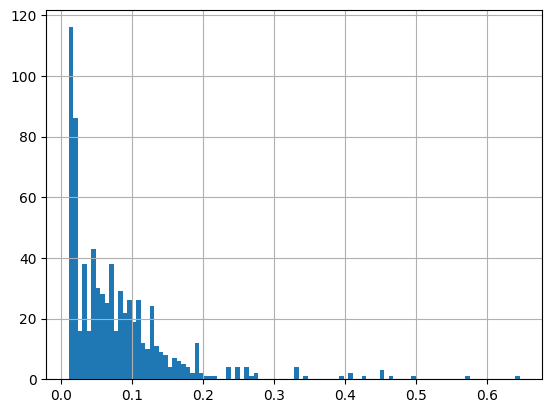

In [16]:
# For a sample player_1 in ds, plot target distribution
players_ocurrences = ds["player_1"].value_counts().sort_values(ascending=False)
sample_player = players_ocurrences.index[0]

sample_player_ds = ds[ds["player_1"] == sample_player]
sample_player_ds["target"].hist(bins=100)

(82550, 33448, 0.7116502008655322, 0.28834979913446784)

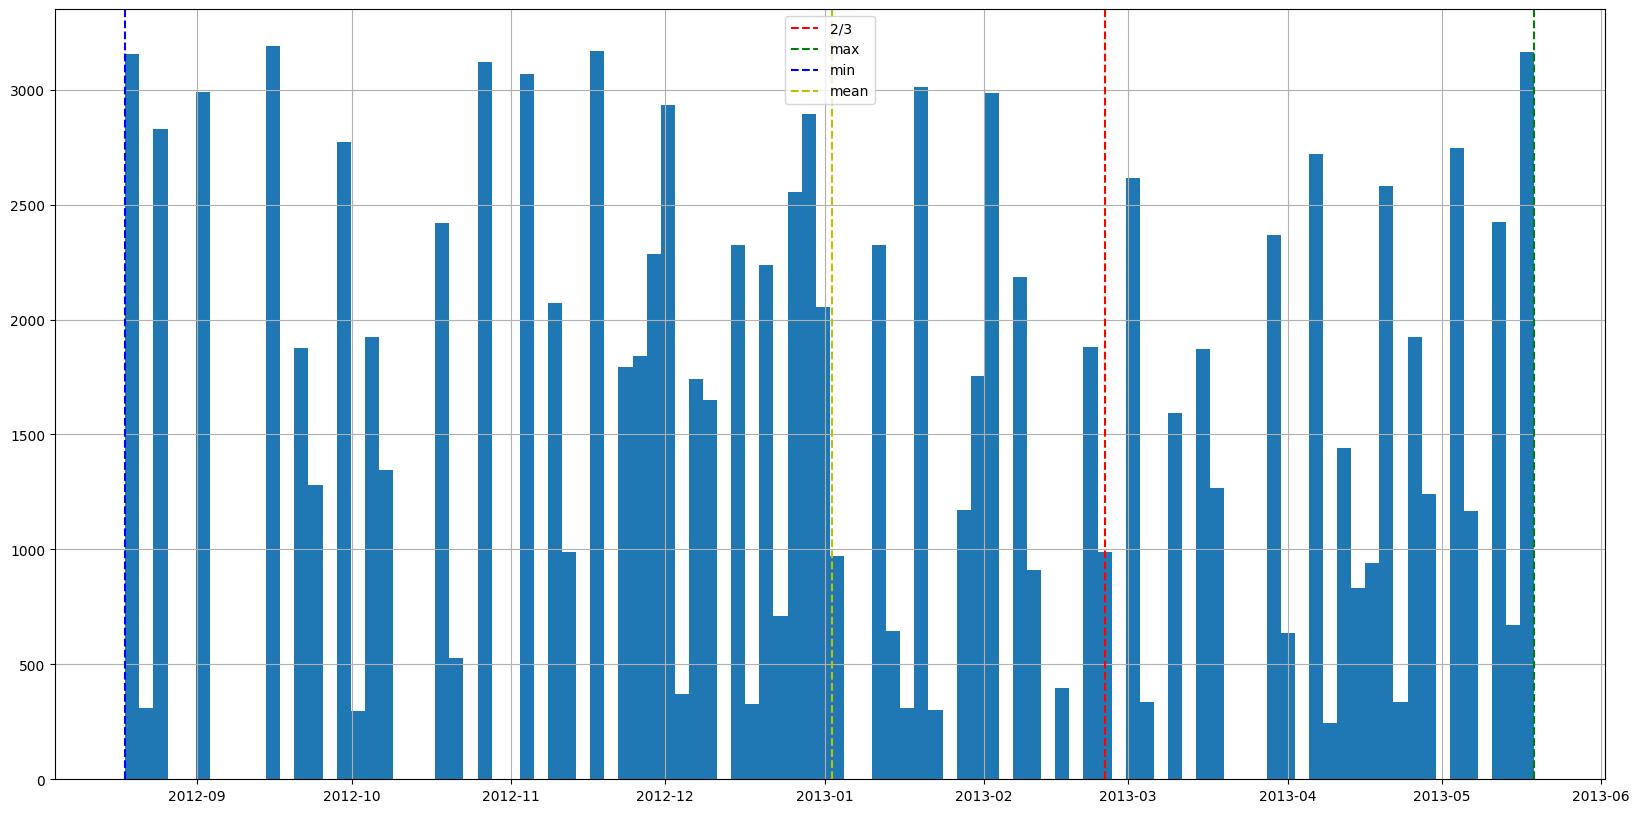

In [17]:
fig, ax = plt.subplots(figsize=(20, 10))
dates.hist(bins=100, ax=ax)

# Plot lines for date_2_3, dates.max(), dates.min(), dates.mean()
ax.axvline(date_2_3, color="r", linestyle="--", label="2/3")
ax.axvline(dates.max(), color="g", linestyle="--", label="max")
ax.axvline(dates.min(), color="b", linestyle="--", label="min")
ax.axvline(dates.mean(), color="y", linestyle="--", label="mean")

ax.legend()

left_c = ds[ds["date"] < date_2_3].shape[0]
right_c = ds[ds["date"] >= date_2_3].shape[0]

left_c, right_c, left_c / (right_c + left_c), right_c / (right_c + left_c)

### Train-Test Split

In [18]:
# Select pairs of player_1 and player_2 that appear in the dataset
# Keep them in a test set

pairs = ds[["player_1", "player_2"]].drop_duplicates()
sample_pairs = pairs.sample(100)

test = ds[
    ds["player_1"].isin(sample_pairs["player_1"])
    & ds["player_2"].isin(sample_pairs["player_2"])
]
train = ds[
    ~ds["player_1"].isin(sample_pairs["player_1"])
    | ~ds["player_2"].isin(sample_pairs["player_2"])
    | ~ds["player_1"].isin(sample_pairs["player_2"])
    | ~ds["player_2"].isin(sample_pairs["player_1"])
]

train_left = train[train["date"] < date_2_3]
test_right = test[test["date"] >= date_2_3]

## Basic XGB Reg

In [6]:
xgb_model = xgb.XGBRegressor()

X_train = train_left.drop(
    columns=["player_1", "player_2", "target", "date", "partido_id"]
)
y_train = train_left["target"]

X_test = test_right.drop(
    columns=["player_1", "player_2", "target", "date", "partido_id"]
)
y_test = test_right["target"]

xgb_model.fit(X_train, y_train)

sc = xgb_model.score(X_test, y_test)

mse = mean_squared_error(y_test, xgb_model.predict(X_test))

sc, mse

(-0.06702807161141622, np.float64(0.015836658410591144))

(0.0, 1.0)

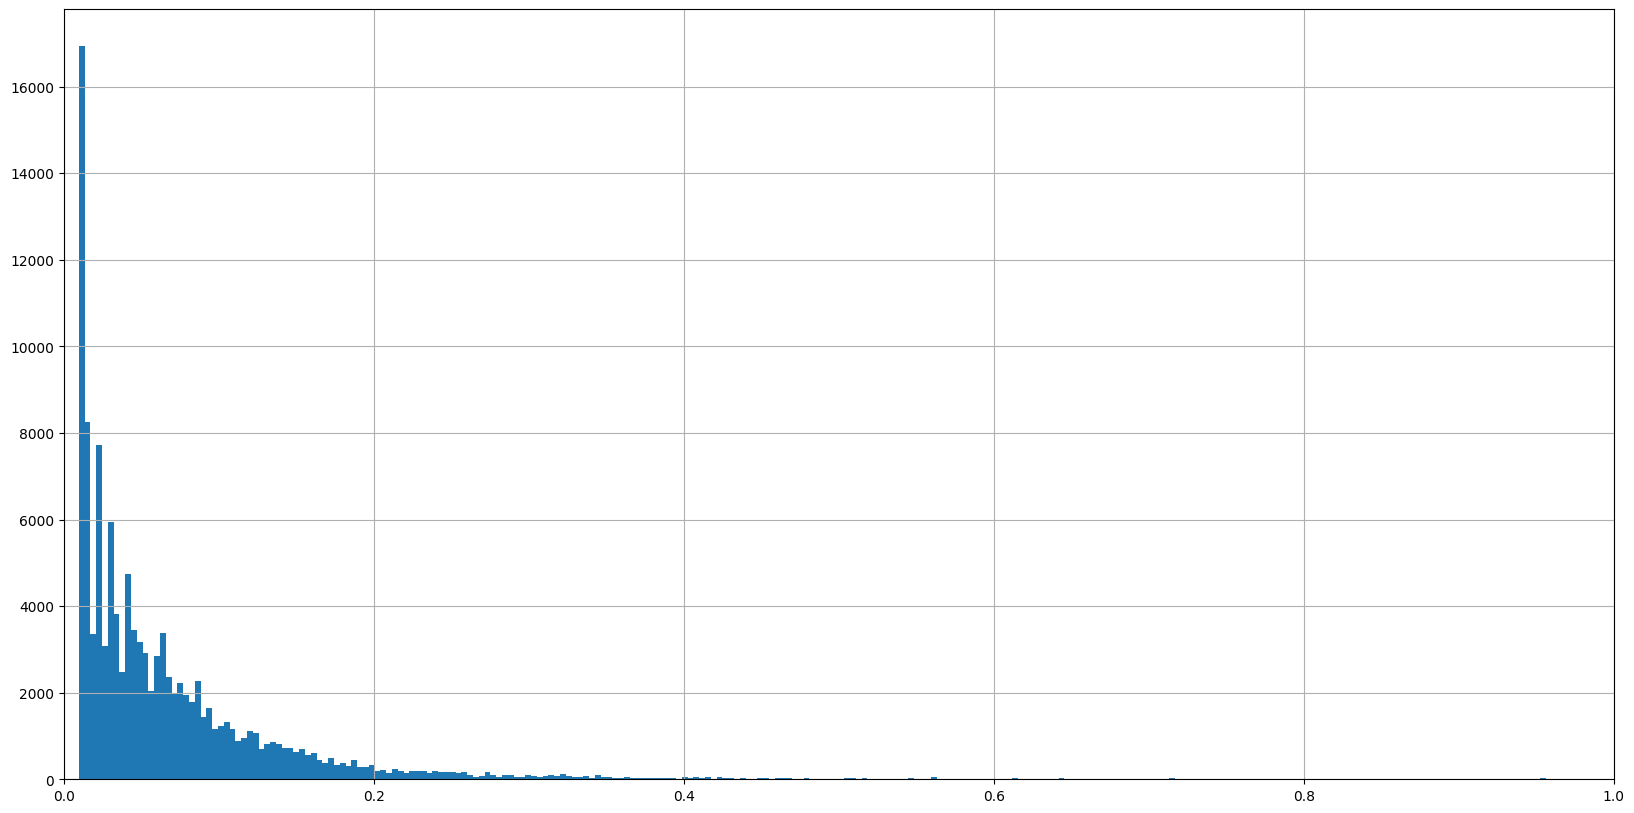

In [7]:
fig, ax = plt.subplots(figsize=(20, 10))

ds["target"].hist(bins=1000, ax=ax)

ax.set_xlim(0, 1)

In [8]:
# Variance, mean, std, min, max for target

ds["target"].var(), ds["target"].mean(), ds["target"].std(), ds["target"].min(), ds["target"].max()

(np.float64(0.008503244578030554),
 np.float64(0.07147860218704535),
 np.float64(0.09221303908900604),
 np.float64(0.009765625),
 np.float64(3.750000000000013))

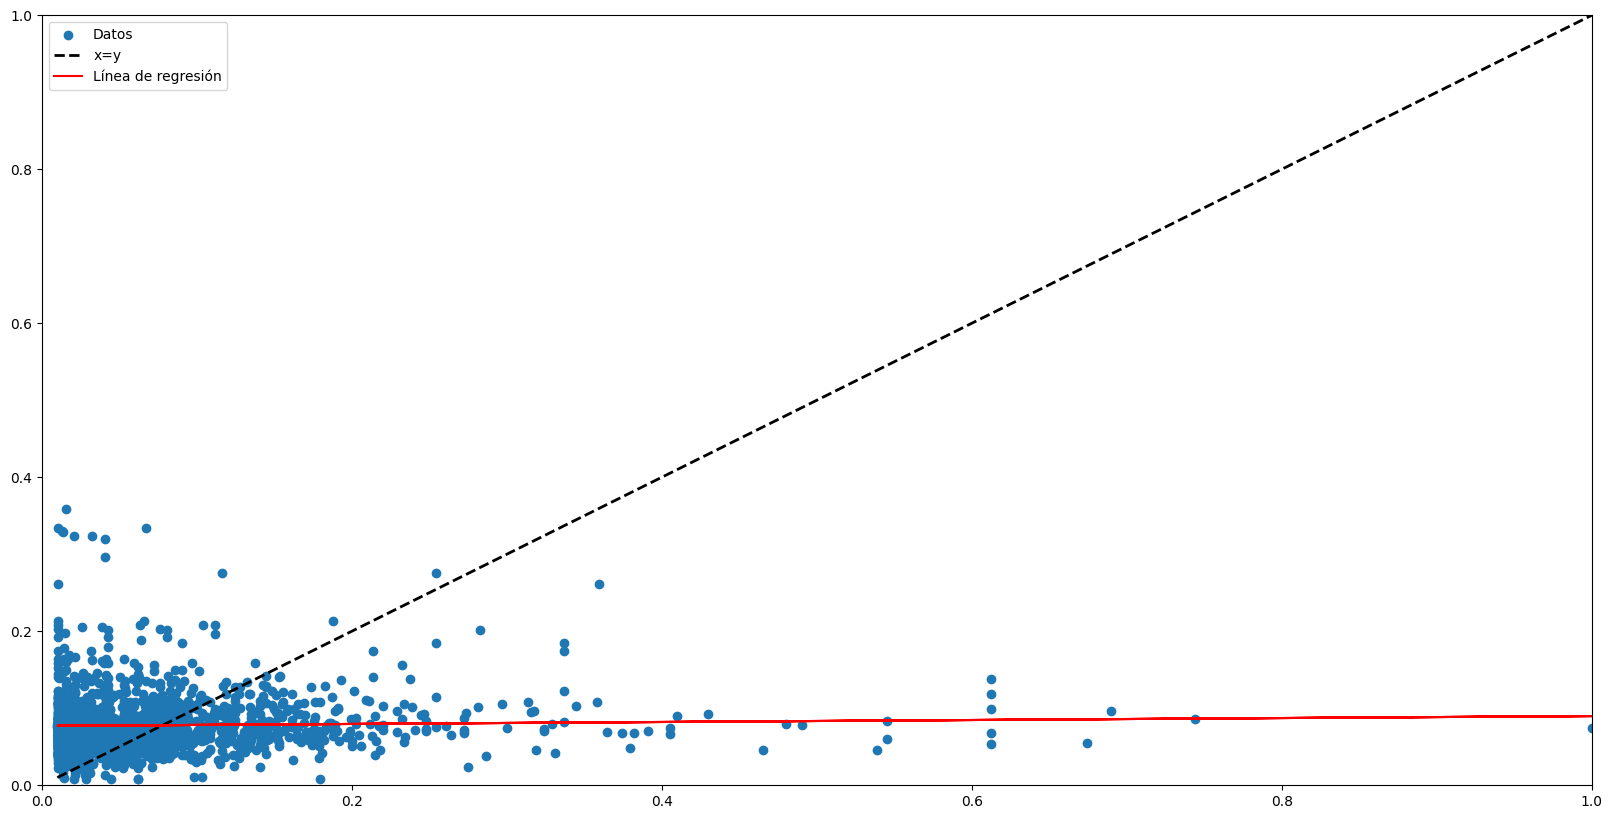

In [9]:
# Datos de prueba y predicciones
y_test = np.array(y_test)
y_pred = xgb_model.predict(X_test)

# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(20, 10))

# Dibujar el gráfico de dispersión
ax.scatter(y_test, y_pred, label="Datos")

# Dibujar la línea x=y
ax.plot(
    [y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "k--", lw=2, label="x=y"
)

# Calcular la línea de regresión
reg = LinearRegression().fit(y_test.reshape(-1, 1), y_pred)
y_pred_line = reg.predict(y_test.reshape(-1, 1))

# Dibujar la línea de regresión
ax.plot(y_test, y_pred_line, color="red", label="Línea de regresión")

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

# Añadir leyenda
ax.legend()

# Mostrar el gráfico
plt.show()


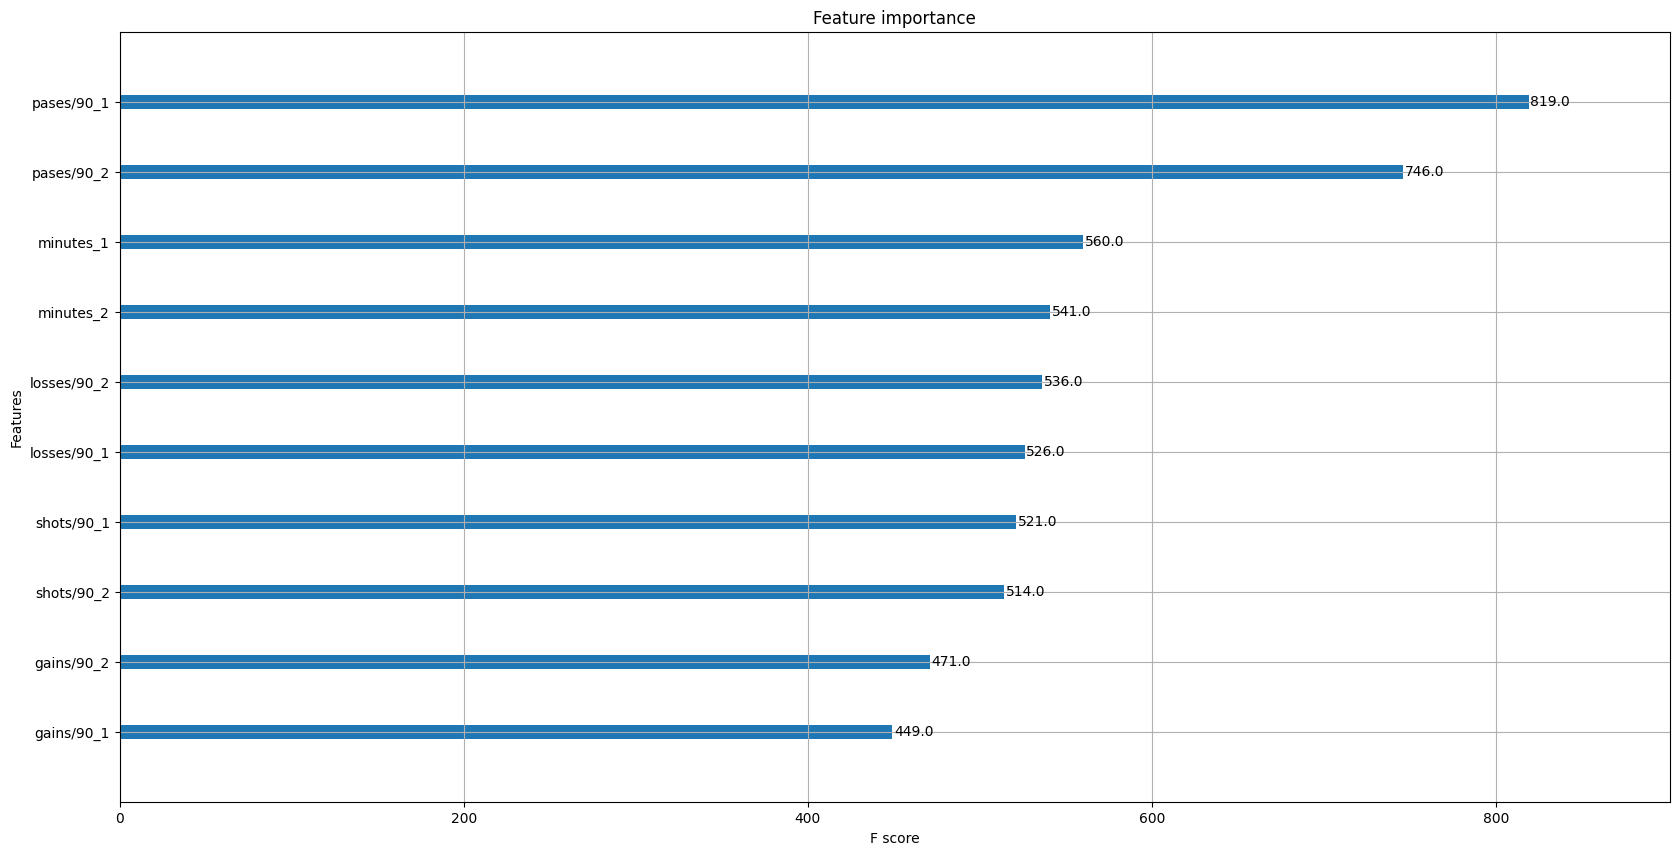

In [10]:
# Feature importance


fig, ax = plt.subplots(figsize=(20, 10))

plot_importance(xgb_model, ax=ax)

plt.show()

## Player Custom Features

In [19]:
epl = leer_excel("../SampleData/epl.xlsx")

In [20]:
partidos = separar_partidos(epl)
partidos = [partido for partido in partidos if partido["date"].values[0] > date_2_3]

sample_partido = partidos[np.random.randint(len(partidos))]

equipos = separar_partido_en_equipo_pov(sample_partido)
sample_equipo = equipos[np.random.randint(2)]
lineups = separar_partido_del_equipo_en_lineups(sample_equipo)
sample_lineup = lineups[np.random.randint(2)]
jugadores = get_jugadores(sample_lineup)

jugador = jugadores[np.random.randint(len(jugadores))]
lineups = separar_partido_del_equipo_en_lineups(sample_equipo)
psls_diffs = np.array([psl_estimator(build_Q(build_R(lineup))) for lineup in lineups])
lineup_durations = np.array([get_lineup_duration(lineup) for lineup in lineups])

In [21]:
def get_features(player_1, partido):
    # For a given player, get aggregated features for all matches played before partido
    # home_team_id if player_1 is in home team, away_team_id if player_1 is in away team
    team_id = partido[partido["player_id"] == player_1]["team_id"].values[0]

    player_data = {
        "pases/90": 0,
        "shots/90": 0,
        "losses/90": 0,
        "gains/90": 0,
        "minutes": 0,
    }

    # Get all matches played
    date = partido["date"].values[0]
    prev_matches = epl[epl["date"] < date]
    for partido in separar_partidos(prev_matches):
        for equipo in separar_partido_en_equipo_pov(partido):
            if equipo["team_id"].values[0] == team_id:
                if player_1 in get_jugadores(equipo):
                    for lineup in separar_partido_del_equipo_en_lineups(equipo):
                        players = get_jugadores(lineup)
                        if player_1 in players:
                            minutes = get_lineup_duration(lineup)
                            if minutes == 0:
                                continue

                            player_data["shots/90"] += get_ratio_shots(lineup, player_1)
                            player_data["losses/90"] += get_ratio_loss(lineup, player_1)
                            player_data["gains/90"] += get_ratio_gains(lineup, player_1)

                            player_data["minutes"] += minutes

                            passes = lineup[
                                (lineup["player_id"] == player_1)
                                & (lineup["type"] == 1)
                                & (lineup["outcome"] == 1)
                            ]

                            player_data["pases/90"] += passes.shape[0] / minutes

    return player_data

In [24]:
X_test.shape

(1422, 10)

In [13]:
def predicted_psl(p1: int, lineups: List[List[int]], model: RegressorMixin) -> TransitionMatrix:
    # Given Q and p1, update value for passes from p1 to every other player, and from every other player to p1
    counter = 0
    psls = []
    for lineup in lineups:
        jugadores = get_jugadores(lineup)
        R = build_R(lineup)
        for i, player in enumerate(jugadores):
            if player == p1:
                p1_features = pd.DataFrame([get_features(player, lineup)])
                for j, player2 in enumerate(jugadores):
                    if player2 != player:
                        counter += 1
                        p2_features = pd.DataFrame([get_features(player2, lineup)])
                        R[i + 1, j + 1] = model.predict(
                            pd.concat([p1_features, p2_features]).values.reshape(1, -1)
                        )[0]
                        R[j + 1, i + 1] = model.predict(
                            pd.concat([p2_features, p1_features]).values.reshape(1, -1)
                        )[0]

        Q = build_Q(R)
        psls.append(psl_estimator(Q))

    # print(counter)
    lineup_durations = np.array([get_lineup_duration(lineup) for lineup in lineups])

    return np.average(psls, weights=lineup_durations)

In [109]:

psl_ = predicted_psl(jugador, lineups, xgb_model)
psl = team_psl(sample_equipo)

psl, psl_, mean_squared_error([psl], [psl_])

30


(np.float64(0.019619676938909286),
 np.float64(0.01959153180420649),
 np.float64(7.921486074386319e-10))

In [110]:
bad_model = xgb.XGBRegressor(max_depth=1, n_estimators=1)
bad_model.fit(X_train, y_train)

psl_ = predicted_psl(jugador, lineups, bad_model)
psl = team_psl(sample_equipo)

psl, psl_, mean_squared_error([psl], [psl_])

30


(np.float64(0.019619676938909286),
 np.float64(0.01946529511486377),
 np.float64(2.383374759562125e-08))

In [111]:
sample_pairs

,player_1,player_2
5305,39529.0,11212.0
6172,19151.0,26900.0
13335,5750.0,49949.0
274939,76227.0,9110.0
108300,76359.0,13017.0
...,...,...
18180,40799.0,38429.0
191760,18681.0,59940.0
6698,18073.0,8380.0
182245,41823.0,48759.0


In [25]:
date = date_2_3
matches = epl[epl["date"] >= date]

In [190]:

# psls_diffs: List[Tuple[float, float]] = []
model = xgb_model

# Pre-caching jugadores and R for each lineup to avoid recomputation
iterator = tqdm(separar_partidos(matches))
for pi, partido in enumerate(iterator):
    try:
        match_id = partido["match_id"].values[0]
    except:
        pass
    for equipo in separar_partido_en_equipo_pov(partido):
        team_psls = []
        team_alt_psls = []

        lineups = separar_partido_del_equipo_en_lineups(equipo)
        lineup_durations = np.array([get_lineup_duration(lineup) for lineup in lineups])

        for li, lineup in enumerate(lineups):
            jugadores = get_jugadores(lineup)
            R = build_R(lineup)

            team_psls.append(psl_estimator(build_Q(R)))

            for i, player in enumerate(jugadores):
                if player in sample_pairs["player_1"].values:
                    p1_features = pd.DataFrame([get_features(player, lineup)])
                    for j, player2 in enumerate(jugadores):
                        if player2 != player:

                            p2_features = pd.DataFrame([get_features(player2, lineup)])

                            q_1_2 = model.predict(
                                pd.concat([p1_features, p2_features]).values.reshape(
                                    1, -1
                                )
                            )[0]

                            q_2_1 = model.predict(
                                pd.concat([p2_features, p1_features]).values.reshape(
                                    1, -1
                                )
                            )[0]

                            R[i + 1, j + 1] = q_1_2
                            R[j + 1, i + 1] = q_2_1

            team_alt_psls.append(psl_estimator(build_Q(R)))
            try:
                iterator.set_postfix(
                    {
                        f"sub_psls": np.average(
                            team_psls, weights=lineup_durations[: li + 1]
                        ),
                        f"sub_alt_psls": np.average(
                            team_alt_psls, weights=lineup_durations[: li + 1]
                        ),
                        f"lineup_count": li + 1,
                        "psl_diff": np.mean(
                            [abs(psl - psl_alt) for psl, psl_alt in psls_diffs]
                        ),
                        "current_psl_diff": f"psl: {psl}, psl_alt: {psl_alt}, diff: {abs(psl - psl_alt)}",
                        f"psls": str(psls_diffs),
                    }
                )
            except:
                print(team_psls)
                print(lineup_durations[: li + 1])
                print(lineup_durations, li)

        psl = np.average(team_psls, weights=lineup_durations)
        psl_alt = np.average(team_alt_psls, weights=lineup_durations)
        psls_diffs.append((psl, psl_alt))

        iterator.set_postfix(
            {
                "psl_diff": np.mean(
                    [abs(psl - psl_alt) for psl, psl_alt in psls_diffs]
                ),
                "current_psl_diff": f"psl: {psl}, psl_alt: {psl_alt}, diff: {abs(psl - psl_alt)}",
                f"psls": str(psls_diffs),
            }
        )


psls_diffs_ = np.array(psls_diffs)

 76%|███████▌  | 84/111 [1:56:29<1:24:32, 187.85s/it, sub_psls=0.0119, sub_alt_psls=0.0111, lineup_count=2, psl_diff=0.00166, current_psl_diff=psl: 0.015211070629024007, psl_alt: 0.017996207580289, diff: 0.0027851369512649944, psls=[(np.float64(0.04044878811695399), np.float64(0.0344586584787615)), (np.float64(0.0222947956239485), np.float64(0.019796164615056275)), (np.float64(0.017318814309279947), np.float64(0.017318814309279947)), (np.float64(0.018974667303509482), np.float64(0.01790010303098091)), (np.float64(0.02922390615638698), np.float64(0.02756447029950026)), (np.float64(0.022701932636816035), np.float64(0.02584750579477674)), (np.float64(0.016573557775754477), np.float64(0.015376608689158456)), (np.float64(0.04063383265249436), np.float64(0.04346191886349149)), (np.float64(0.07447196337520942), np.float64(0.07760764764974985)), (np.float64(0.0016033750425037937), np.float64(0.0016543614043618038)), (np.float64(0.041886066659706525), np.float64(0.041421435431468145)), (np.floa

Error: La matriz es singular y no se puede invertir.
Singular matrix


100%|██████████| 111/111 [3:23:54<00:00, 110.22s/it, psl_diff=0.00188, current_psl_diff=psl: 0.016875561636353623, psl_alt: 0.017026304188134576, diff: 0.0001507425517809531, psls=[(np.float64(0.04044878811695399), np.float64(0.0344586584787615)), (np.float64(0.0222947956239485), np.float64(0.019796164615056275)), (np.float64(0.017318814309279947), np.float64(0.017318814309279947)), (np.float64(0.018974667303509482), np.float64(0.01790010303098091)), (np.float64(0.02922390615638698), np.float64(0.02756447029950026)), (np.float64(0.022701932636816035), np.float64(0.02584750579477674)), (np.float64(0.016573557775754477), np.float64(0.015376608689158456)), (np.float64(0.04063383265249436), np.float64(0.04346191886349149)), (np.float64(0.07447196337520942), np.float64(0.07760764764974985)), (np.float64(0.0016033750425037937), np.float64(0.0016543614043618038)), (np.float64(0.041886066659706525), np.float64(0.041421435431468145)), (np.float64(0.0071866709117338525), np.float64(0.00727022296

In [191]:
psls_diffs_arr = np.array(psls_diffs)

In [192]:
len(psls_diffs_arr)

220

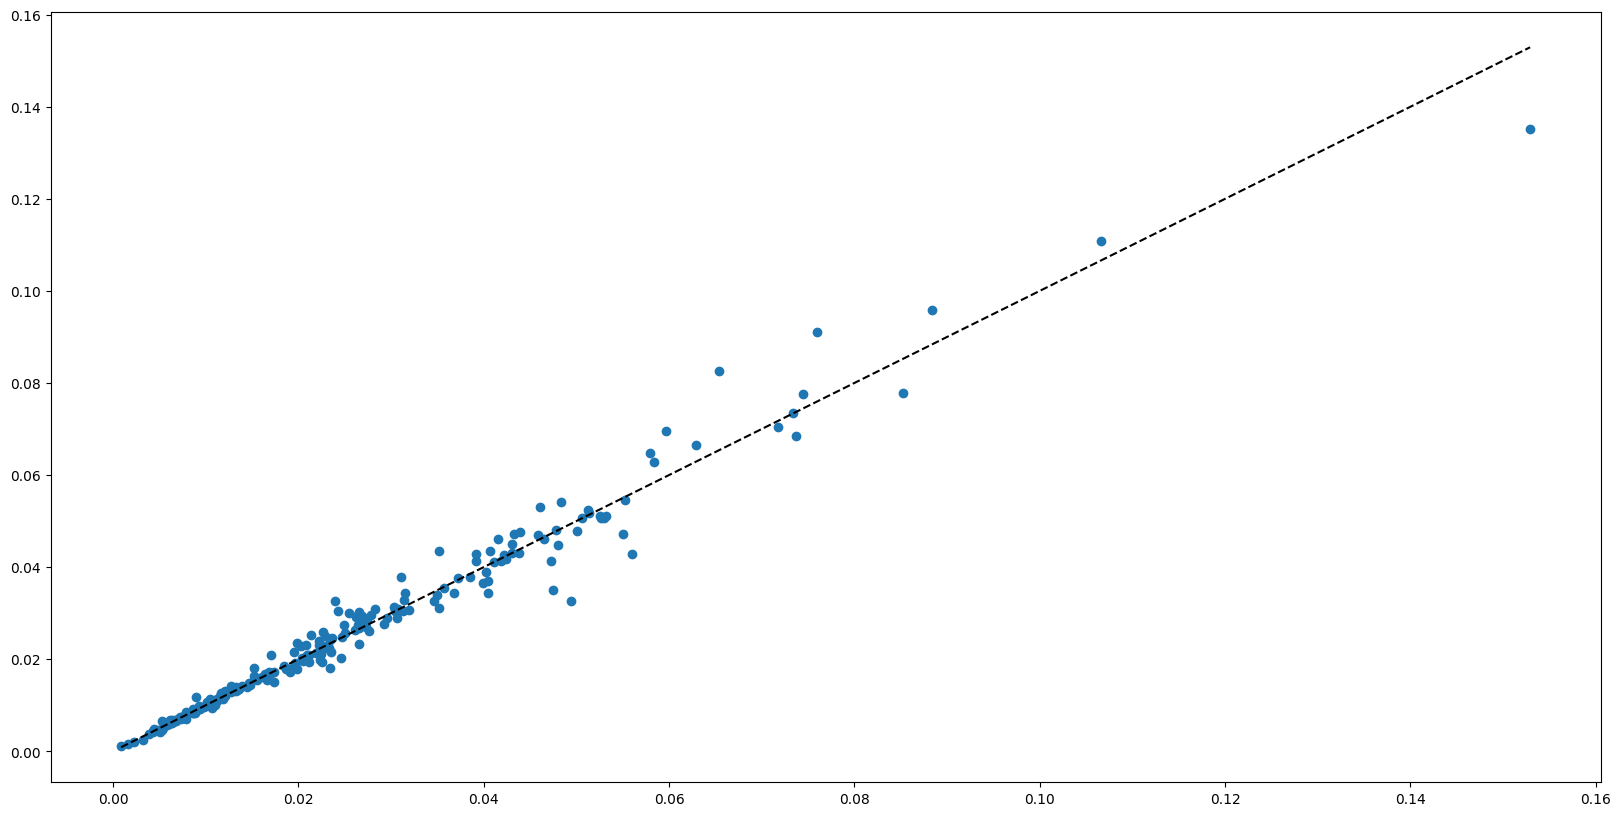

In [193]:
arr = psls_diffs_arr

fig, ax = plt.subplots(figsize=(20, 10))

ax.scatter(arr[:, 0], arr[:, 1])

# Plot y=x for the range of the data
ax.plot([arr[:, 0].min(), arr[:, 0].max()], [arr[:, 0].min(), arr[:, 0].max()], "k--")


### Linear Regression

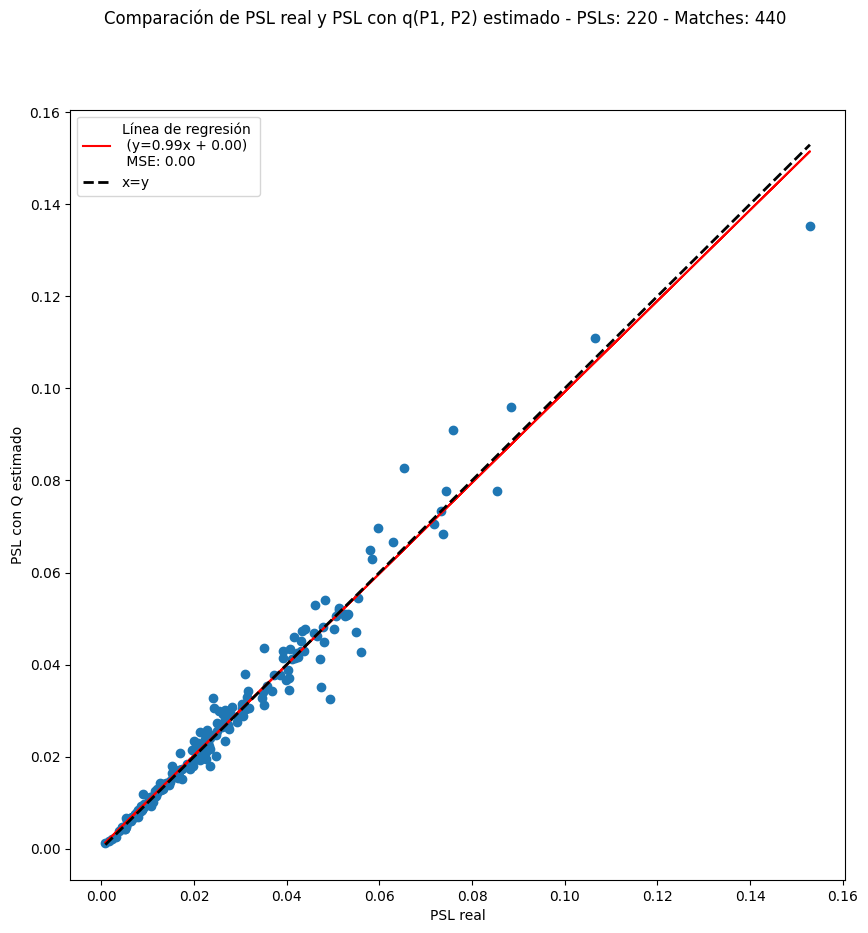

In [194]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Suponiendo que `arr` ya está definido
# Linear regression for the data, compare slope to y=x
reg = LinearRegression().fit(arr[:, 0].reshape(-1, 1), arr[:, 1])
y_pred_line = reg.predict(arr[:, 0].reshape(-1, 1))

# Obtener la pendiente (slope) y la intersección (intercept)
slope = reg.coef_[0]
intercept = reg.intercept_

# Mean squared error
mse = mean_squared_error(arr[:, 0], arr[:, 1])

fig, ax = plt.subplots(figsize=(10, 10))

ax.plot(arr[:, 0], y_pred_line, color="red", label=f"Línea de regresión \n (y={slope:.2f}x + {intercept:.2f}) \n MSE: {mse:.2f}")

ax.scatter(arr[:, 0], arr[:, 1])

# Plot y=x for the range of the data
ax.plot([arr[:, 0].min(), arr[:, 0].max()], [arr[:, 0].min(), arr[:, 0].max()], "k--", lw=2, label="x=y")

ax.set_xlabel("PSL real")
ax.set_ylabel("PSL con Q estimado")

fig.suptitle(
    f"Comparación de PSL real y PSL con q(P1, P2) estimado - PSLs: {len(arr)} - Matches: {len(arr) * 2}"
)

plt.legend()

In [196]:
slope, intercept, mse

(np.float64(0.9874685813616221),
 np.float64(0.0004866092369307101),
 np.float64(1.2440044584277338e-05))

In [195]:
# Save psls_diffs_arr
np.save("psls_diffs_arr.npy", psls_diffs_arr)

In [197]:
# Calculate R^2 

from sklearn.metrics import r2_score

r2_score(arr[:, 0], arr[:, 1])

0.9702628077348673

## Precomputing

In [201]:
max_n_lineups = np.max(
    [
        len(separar_partido_del_equipo_en_lineups(equipo))
        for partido in separar_partidos(epl)
        for equipo in separar_partido_en_equipo_pov(partido)
    ]
)
max_n_lineups

np.int64(4)

### Precompute R

In [221]:
n_matches = len(separar_partidos(epl))

R_storage = np.zeros((n_matches, 2, max_n_lineups, 15, 15))

def precompute_R_matrices(matches, R_storage):
    for pi, partido in enumerate(tqdm(separar_partidos(matches))):
        try:
            match_id = partido["match_id"].values[0]
        except:
            continue

        for team_index, equipo in enumerate(separar_partido_en_equipo_pov(partido)):
            lineups = separar_partido_del_equipo_en_lineups(equipo)

            for lineup_index, lineup in enumerate(lineups):
                jugadores = get_jugadores(lineup)

                # Build the R matrix (14x14)
                R = build_R(lineup)

                # Indexes 1 through 11 are players, both columns and rows
                # Store the R matrix in the storage last 14x14 part of the 15x15 matrix,
                # Save the lineup index in the first column from 1 to 11
                # Also in the first row
                if len(jugadores) > 11:
                    continue
                
                jugadores = np.array(jugadores)
                if len(jugadores) < 11:
                    jugadores = np.pad(jugadores, (0, 11 - len(jugadores)))
                R_storage[pi, team_index, lineup_index, 1:, 1:] = R
                R_storage[pi, team_index, lineup_index, 0, 2:13] = jugadores
                R_storage[pi, team_index, lineup_index, 2:13, 0] = jugadores

precompute_R_matrices(epl, R_storage)

100%|██████████| 380/380 [02:58<00:00,  2.13it/s]


In [229]:
# Save R_storage
np.save("R_storage.npy", R_storage)

In [22]:
R_storage = np.load("R_storage.npy")

In [23]:
def visualize_R_matrix(R):
    # 0, 1:12 are player ids,
    # 1:12, 0 are also player ids,
    # 1:, 1: is the true R matrix, :2f precision

    html = "<table>"
    for i in range(15):
        html += "<tr>"
        for j in range(15):
            if i == 0 and j == 0:
                html += "<td></td>"  # Empty top-left cell
            elif i == 0 and j == 1 or i == 1 and j == 0: # Gain state col/row headers
                html += "<td><b>G</b></td>"
            elif i == 0 and j == 13 or i == 13 and j == 0: # Loss state col/row headers
                html += "<td><b>L</b></td>"
            elif i == 0 and j == 14 or i == 14 and j == 0: # Shots state col/row headers
                html += "<td><b>S</b></td>"
            elif i == 0:
                html += f"<td><b>{int(R[0, j])}</b></td>"  # Column headers
            elif j == 0:
                html += f"<td><b>{int(R[i, 0])}</b></td>"  # Row headers
            else:
                html += f"<td>{R[i, j]:.2f}</td>"  # Data cells
        html += "</tr>"
    html += "</table>"

    display(HTML(html))


visualize_R_matrix(R_storage[0, 0, 0])

,G,17733,19524,15943,20467,80254,8758,42427,17127,43274,28566,59936,L,S
G,0.00,0.19,0.35,0.27,0.23,0.44,0.32,0.37,0.18,0.32,0.47,0.08,0.00,0.00
17733,0.00,0.00,0.08,0.02,0.02,0.02,0.03,0.03,0.00,0.03,0.05,0.00,0.31,0.02
19524,0.00,0.05,0.00,0.05,0.13,0.10,0.13,0.13,0.02,0.13,0.13,0.00,0.47,0.03
15943,0.00,0.03,0.05,0.00,0.08,0.02,0.19,0.16,0.39,0.05,0.11,0.02,0.23,0.02
20467,0.00,0.02,0.03,0.00,0.00,0.11,0.05,0.05,0.02,0.00,0.00,0.00,0.27,0.02
80254,0.00,0.02,0.10,0.10,0.08,0.02,0.13,0.05,0.11,0.08,0.13,0.02,0.37,0.02
8758,0.00,0.05,0.32,0.16,0.05,0.11,0.00,0.10,0.21,0.05,0.21,0.00,0.21,0.00
42427,0.00,0.05,0.10,0.21,0.03,0.02,0.18,0.00,0.05,0.11,0.13,0.00,0.37,0.00
17127,0.00,0.03,0.00,0.37,0.03,0.29,0.11,0.02,0.00,0.02,0.08,0.02,0.08,0.00
43274,0.00,0.05,0.05,0.02,0.00,0.05,0.03,0.11,0.00,0.00,0.00,0.00,0.35,0.03


In [84]:
def R_to_DataFrame(R, jugadores):
    # Given a 14x14 R matrix, and a list of jugadores,
    # return a DataFrame with the R matrix in 1:, 1:
    # and the jugadores in the first row and column, also a G, L, S index/column

    cols = ["G"] + list(jugadores) + ["L", "S"]
    df = pd.DataFrame(R[1:, 1:], index=cols, columns=cols)
    # df.index.name = "State"
    df.columns.name = "State"

    return df

R_example_df = R_to_DataFrame(R_storage[0, 0, 0], R_storage[0, 0, 0, 0, 2:13])

R_example_df.columns

Index([    'G', 17733.0, 19524.0, 15943.0, 20467.0, 80254.0,  8758.0, 42427.0,
       17127.0, 43274.0, 28566.0, 59936.0,     'L',     'S'],
      dtype='object', name='State')

In [85]:
R_example_df.loc["G", 17733]

np.float64(0.19349637194302607)

In [86]:
R_example_df.loc[19524, 17733]

np.float64(0.04837409298575652)

In [87]:
R_storage.shape

(380, 2, 4, 15, 15)

In [89]:
R_to_DataFrame(R_storage[0, 0, 0], R_storage[0, 0, 0, 0, 2:13])

array([[0.        , 0.19349637, 0.35474335, 0.27411986, 0.22574577,
        0.43536684, 0.32249395, 0.37086805, 0.17737167, 0.32249395,
        0.46761623, 0.08062349, 0.        , 0.        ],
       [0.        , 0.        , 0.08062349, 0.0161247 , 0.0161247 ,
        0.0161247 , 0.0322494 , 0.0322494 , 0.        , 0.0322494 ,
        0.04837409, 0.        , 0.30636926, 0.0161247 ],
       [0.        , 0.04837409, 0.        , 0.04837409, 0.12899758,
        0.09674819, 0.12899758, 0.12899758, 0.0161247 , 0.12899758,
        0.12899758, 0.        , 0.46761623, 0.0322494 ],
       [0.        , 0.0322494 , 0.04837409, 0.        , 0.08062349,
        0.0161247 , 0.19349637, 0.16124698, 0.38699274, 0.04837409,
        0.11287288, 0.0161247 , 0.22574577, 0.0161247 ],
       [0.        , 0.0161247 , 0.0322494 , 0.        , 0.        ,
        0.11287288, 0.04837409, 0.04837409, 0.0161247 , 0.        ,
        0.        , 0.        , 0.27411986, 0.0161247 ],
       [0.        , 0.0161247 , 0.0

In [255]:
# R_storage is of shape (n_matches=380, 2, max_n_lineups=4, 15, 15)
# Map the R_to_DataFrame to the last two dimensions of R_storage for every other dim
# But Timing it


timeit.timeit(
    """
R_dfs = np.array(
    [
        [
            [
                R_to_DataFrame(R_storage[pi, ti, li], R_storage[pi, ti, li, 0, 2:13])
                for li in range(R_storage.shape[2])
            ]
            for ti in range(R_storage.shape[1])
        ]
        for pi in range(R_storage.shape[0])
    ]
)
    """,
    globals=globals(),
    number=1,
)

0.33804833400063217

### Precompute Features

In [259]:
def precompute_and_store_features(epl):
    player_features = []

    all_matches = separar_partidos(epl)

    for partido in tqdm(all_matches):
        match_id = partido["match_id"].values[0]
        date = partido["date"].values[0]
        prev_matches = epl[epl["date"] < date]

        for equipo in separar_partido_en_equipo_pov(partido):
            team_id = equipo["team_id"].values[0]
            jugadores = get_jugadores(equipo)

            for jugador in jugadores:
                player_data = {
                    "player_id": jugador,
                    "match_id": match_id,
                    "pases/90": 0,
                    "shots/90": 0,
                    "losses/90": 0,
                    "gains/90": 0,
                    "minutes": 0,
                    "match_date": date,
                }

                for prev_partido in separar_partidos(prev_matches):
                    for prev_equipo in separar_partido_en_equipo_pov(prev_partido):
                        if prev_equipo["team_id"].values[0] == team_id:
                            if jugador in get_jugadores(prev_equipo):
                                for lineup in separar_partido_del_equipo_en_lineups(
                                    prev_equipo
                                ):
                                    if jugador in get_jugadores(lineup):
                                        minutes = get_lineup_duration(lineup)
                                        if minutes == 0:
                                            continue

                                        player_data["shots/90"] += get_ratio_shots(
                                            lineup, jugador
                                        )
                                        player_data["losses/90"] += get_ratio_loss(
                                            lineup, jugador
                                        )
                                        player_data["gains/90"] += get_ratio_gains(
                                            lineup, jugador
                                        )
                                        player_data["minutes"] += minutes

                                        passes = lineup[
                                            (lineup["player_id"] == jugador)
                                            & (lineup["type"] == 1)
                                            & (lineup["outcome"] == 1)
                                        ]
                                        player_data["pases/90"] += (
                                            passes.shape[0] / minutes
                                        )

                player_features.append(player_data)

    # Create DataFrame with MultiIndex
    features_df = pd.DataFrame(player_features)
    features_df.set_index(["player_id", "match_id"], inplace=True)

    return features_df


# Precompute and store features
player_features_df = precompute_and_store_features(epl)

# Save to disk
player_features_df.to_parquet("player_features.parquet")

 21%|██        | 79/380 [04:00<15:14,  3.04s/it]


KeyboardInterrupt: 

In [48]:
def precompute_and_store_features_optimized(epl):
    # Instead of going through all the previous matches for each player in each new match,
    # we can use the precomputed features to get the data for each player in each match

    player_stats = []

    all_matches = separar_partidos(epl)

    # Solving with Dinamic Programming
    # For each match m,
    # the features of a player in the match m
    # are the stats of the player until match m-1 included
    # stats are: pases/90, shots/90, losses/90, gains/90, minutes

    # The features of a player in the match 0 are all stats = 0

    # First get player_stats for all players in all matches
    # Then get the features for each player in each match

    for partido in tqdm(all_matches):
        match_id = partido["match_id"].values[0]
        date = partido["date"].values[0]

        for equipo in separar_partido_en_equipo_pov(partido):
            team_id = equipo["team_id"].values[0]
            jugadores = get_jugadores(equipo)

            for jugador in jugadores:
                player_data = {
                    "player_id": jugador,
                    "match_id": match_id,
                    "pases/90": 0,
                    "shots/90": 0,
                    "losses/90": 0,
                    "gains/90": 0,
                    "minutes": 0,
                    "match_date": date,
                }

                for lineup in separar_partido_del_equipo_en_lineups(equipo):
                    if jugador in get_jugadores(lineup):
                        minutes = get_lineup_duration(lineup)
                        if minutes == 0:
                            continue

                        player_data["shots/90"] += get_ratio_shots(lineup, jugador)
                        player_data["losses/90"] += get_ratio_loss(lineup, jugador)
                        player_data["gains/90"] += get_ratio_gains(lineup, jugador)
                        player_data["minutes"] += minutes

                        pases = lineup[
                            (lineup["player_id"] == jugador)
                            & (lineup["type"] == 1)
                            & (lineup["outcome"] == 1)
                        ]
                        player_data["pases/90"] += pases.shape[0] / minutes

                player_stats.append(player_data)

    # Create DataFrame with MultiIndex
    player_stats_df = pd.DataFrame(player_stats)
    player_stats_df["match_date"] = pd.to_datetime(player_stats_df["match_date"])

    # Second part

    # Sort all_matches by date, newest first
    all_matches = sorted(all_matches, key=lambda x: x["date"].values[0], reverse=True)

    player_features_df = pd.DataFrame(
        columns=[
            "player_id",
            "match_id",
            "pases/90",
            "shots/90",
            "losses/90",
            "gains/90",
            "minutes",
            "match_date",
        ],
    )

    # For each match, get the features for each player
    for partido in tqdm(all_matches):
        match_id = partido["match_id"].values[0]
        date = partido["date"].values[0]

        for equipo in separar_partido_en_equipo_pov(partido):
            team_id = equipo["team_id"].values[0]
            jugadores = get_jugadores(equipo)

            for jugador in jugadores:
                # Get the stats for the player until match m-1 included (match_id < match_id)
                # Sum all the stats for the player in all matches until match m-1 included

                prev_stats = player_stats_df[
                    (player_stats_df["match_date"] < date) & 
                    (player_stats_df["player_id"] == jugador)
                ]
                # TypeError: 'DatetimeArray' with dtype datetime64[ns] does not support reduction 'sum'
                # Drop the match_date column
                prev_stats = prev_stats.drop(columns=["match_date", "match_id", "player_id"])
                prev_stats_sum = prev_stats.sum()

                player_data = {
                    "player_id": jugador,
                    "match_id": match_id,
                    "pases/90": prev_stats_sum["pases/90"],
                    "shots/90": prev_stats_sum["shots/90"],
                    "losses/90": prev_stats_sum["losses/90"],
                    "gains/90": prev_stats_sum["gains/90"],
                    "minutes": prev_stats_sum["minutes"],
                    "match_date": date,
                }

                player_data_df = pd.DataFrame([player_data])
                player_features_df = pd.concat([player_features_df, player_data_df], ignore_index=True)

    return player_features_df.set_index(["player_id", "match_id"])

In [25]:
test_matches = epl[epl["date"] >= date_2_3]

In [28]:
# Precompute and store features
# player_features_df = precompute_and_store_features_optimized(test_matches)

NameError: name 'precompute_and_store_features_optimized' is not defined

In [283]:
!pip install pyarrow fastparquet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 6.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 910.5/910.5 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 6.4 MB/s eta 0:00:00ta 0:00:01


In [297]:
# Save to disk
# player_features_df.to_parquet("player_features_optimized.parquet")

## Load Player Features

In [73]:
def load_player_features_dataframe(filepath):
    # Load the DataFrame from disk
    return pd.read_parquet(filepath)


def get_features_from_df(player_id, match_id, features_df, cols):
    try:
        return features_df.loc[(player_id, match_id)][cols].to_dict()

    except KeyError:
        # return {
        #     "pases/90": 0,
        #     "shots/90": 0,
        #     "losses/90": 0,
        #     "gains/90": 0,
        #     "minutes": 0,
        # }

        return {col : 0 for col in cols}

player_features_df = load_player_features_dataframe("player_features_optimized.parquet")

In [30]:
# Get columns from xgb_model
X_train.columns

Index(['pases/90_1', 'shots/90_1', 'losses/90_1', 'gains/90_1', 'minutes_1',
       'pases/90_2', 'shots/90_2', 'losses/90_2', 'gains/90_2', 'minutes_2'],
      dtype='object')

In [31]:
# Get columns from xgb_model
player_features_df.columns

Index(['pases/90', 'shots/90', 'losses/90', 'gains/90', 'minutes',
       'match_date'],
      dtype='object')

## PSL Tools

In [67]:
def replace_q_values(
    R_df,
    model,
    p1,
    p2,
    features_df,
    p1_features=None,
    model_cols=list(set([col[:-2] for col in X_train.columns])),
):
    # Given a 14x14 R matrix, replace the q values for p1, p2 with the model predictions
    # Get the features for p1 and p2 from the features_df
    # Get the model predictions for p1, p2
    # Replace the values in the R matrix
    # Return the updated R matrix

    if p1_features is None:
        p1_features = pd.DataFrame([get_features_from_df(p1, 0, features_df, model_cols)])

    p2_features = pd.DataFrame([get_features_from_df(p2, 0, features_df, model_cols)])

    try:
        p1_features = p1_features[model_cols]
        p2_features = p2_features[model_cols]
    except Exception as e:
        print(p1, p1_features)
        print(p2, p2_features)
        print(model_cols)

        raise e

    q_1_2 = model.predict(
        pd.concat([p1_features, p2_features]).values.reshape(1, -1)
    )[0]

    q_2_1 = model.predict(
        pd.concat([p2_features, p1_features]).values.reshape(1, -1)
    )[0]

    R_df.loc[p1, p2] = q_1_2
    R_df.loc[p2, p1] = q_2_1

    return R_df, q_1_2, q_2_1

match_id_RS_index_map = {
    m: i
    for i, m in enumerate(
        [partido["match_id"].values[0] for partido in separar_partidos(epl)]
    )
}

def match_id_2_RS_index(match_id):
    return match_id_RS_index_map[match_id]


def get_psl_diffs(
    R_storage, model, sample_pairs, matches, player_features_df, model_cols=list(set([col[:-2] for col in X_train.columns]))
):
    psls_diffs = []
    partidos = separar_partidos(matches)
    # pi_overhead = 380 - len(partidos)
    no_updates = 0
    updates = 0

    iterator = tqdm(partidos)
    for pi, partido in enumerate(iterator):
        try:
            match_id = partido["match_id"].values[0]
        except:
            continue

        for ti, equipo in enumerate(separar_partido_en_equipo_pov(partido)):
            team_psls = []
            team_alt_psls = []

            lineups = separar_partido_del_equipo_en_lineups(equipo)
            lineup_durations = np.array([get_lineup_duration(lineup) for lineup in lineups])

            for li, lineup in enumerate(lineups):
                jugadores = get_jugadores(lineup)
                team_rs_index = match_id_2_RS_index(match_id)
                R_f_s = R_storage[team_rs_index, ti, li].copy()
                # print("R from Storage:", R_f_s.shape)
                R_df = R_to_DataFrame(R_f_s, R_f_s[0, 2:13])
                # print("R DF:", R_df.shape)

                R = R_f_s[1:, 1:]
                # print("R 14x14: ", R.shape)
                real_psl = psl_estimator(build_Q(R))
                team_psls.append(real_psl)

                R_mod = R.copy()

                # Check jugadores are in R_df [0, 2:13]
                if not all([jugador in R_df.columns for jugador in jugadores]):
                    # print(pi + pi_overhead, ti, li, jugadores)
                    # print(lineup_durations[li])
                    # visualize_R_matrix(R_f_s)
                    team_alt_psls.append(0)
                    continue

                for i, player in enumerate(jugadores):
                    if player in sample_pairs["player_1"].values:
                        p1_features = pd.DataFrame(
                            [
                                get_features_from_df(
                                    player, match_id, player_features_df, model_cols
                                )
                            ]
                        )

                        for j, player2 in enumerate(jugadores):
                            if player2 != player:
                                # tmp = R_df.loc[player, player2]
                                tmp_R = R[i + 1, j + 1]
                                R_df, q_1_2, q_2_1 = replace_q_values(
                                    R_df,
                                    model,
                                    player,
                                    player2,
                                    player_features_df,
                                    p1_features,
                                    model_cols,
                                )
                                R_mod[i + 1, j + 1] = q_1_2
                                R_mod[j + 1, i + 1] = q_2_1
                                # post = R_df.loc[player, player2]
                                post_R = R_mod[i + 1, j + 1]
                                # if tmp == post:
                                # raise ValueError("No update")

                                if tmp_R == post_R:
                                    no_updates += 1
                                else:
                                    updates += 1
                                    # print(no_updates)
                                    # raise ValueError("No update")

                # R = np.array(R_df.values)
                # print(R.shape)
                modified_psl = psl_estimator(build_Q(R_mod))
                if real_psl == modified_psl:
                    iterator.set_postfix(
                        {
                            "no_updates": no_updates,
                            "updates": updates,
                            
                        }
                    )

                    # raise ValueError("No update")
                team_alt_psls.append(modified_psl)

            psl = np.average(team_psls, weights=lineup_durations)
            psl_alt = np.average(team_alt_psls, weights=lineup_durations)
            psls_diffs.append((psl, psl_alt))

    return psls_diffs

In [33]:
match_id_RS_index_map

{np.int64(441999): 0,
 np.int64(442000): 1,
 np.int64(442001): 2,
 np.int64(442002): 3,
 np.int64(442003): 4,
 np.int64(442004): 5,
 np.int64(442005): 6,
 np.int64(442006): 7,
 np.int64(442007): 8,
 np.int64(442008): 9,
 np.int64(442009): 10,
 np.int64(442010): 11,
 np.int64(442011): 12,
 np.int64(442012): 13,
 np.int64(442013): 14,
 np.int64(442014): 15,
 np.int64(442015): 16,
 np.int64(442016): 17,
 np.int64(442017): 18,
 np.int64(442018): 19,
 np.int64(442019): 20,
 np.int64(442020): 21,
 np.int64(442021): 22,
 np.int64(442022): 23,
 np.int64(442023): 24,
 np.int64(442024): 25,
 np.int64(442025): 26,
 np.int64(442026): 27,
 np.int64(442027): 28,
 np.int64(442028): 29,
 np.int64(442029): 30,
 np.int64(442030): 31,
 np.int64(442031): 32,
 np.int64(442032): 33,
 np.int64(442033): 34,
 np.int64(442034): 35,
 np.int64(442035): 36,
 np.int64(442036): 37,
 np.int64(442037): 38,
 np.int64(442038): 39,
 np.int64(442039): 40,
 np.int64(442040): 41,
 np.int64(442041): 42,
 np.int64(442042): 43

In [34]:
psl_diffs_arr_2 = np.array(
    get_psl_diffs(R_storage, xgb_model, sample_pairs, test_matches, player_features_df)
)

 15%|█▌        | 17/111 [00:05<00:27,  3.48it/s, no_updates=0, updates=2239]

Error: La matriz es singular y no se puede invertir.
Singular matrix


 77%|███████▋  | 85/111 [00:28<00:06,  3.78it/s, no_updates=0, updates=11431]

Error: La matriz es singular y no se puede invertir.
Singular matrix


100%|██████████| 111/111 [00:37<00:00,  2.98it/s, no_updates=0, updates=14830]


In [35]:
def evaluate_psl_diffs(arr, ax=None, plot=True):
    # Linear regression for the data, compare slope to y=x
    reg = LinearRegression().fit(arr[:, 0].reshape(-1, 1), arr[:, 1])
    y_pred_line = reg.predict(arr[:, 0].reshape(-1, 1))

    # Obtener la pendiente (slope) y la intersección (intercept)
    slope = reg.coef_[0]
    intercept = reg.intercept_

    # Mean squared error
    mse = mean_squared_error(arr[:, 0], arr[:, 1])

    if plot:
        if ax is None:
            fig, ax = plt.subplots(figsize=(10, 10))

        ax.plot(
            arr[:, 0],
            y_pred_line,
            color="red",
            label=f"Línea de regresión \n (y={slope:.2f}x + {intercept:.2f}) \n MSE: {mse:.2f}",
        )

        ax.scatter(arr[:, 0], arr[:, 1])

        # Plot y=x for the range of the data
        ax.plot(
            [arr[:, 0].min(), arr[:, 0].max()],
            [arr[:, 0].min(), arr[:, 0].max()],
            "k--",
            lw=2,
            label="x=y",
        )

        ax.set_xlabel("PSL real")
        ax.set_ylabel("PSL con Q estimado")

        ax.set_title(
            f"Comparación de PSL real y PSL con q(P1, P2) estimado - PSLs: {len(arr)} - Matches: {len(arr) / 2}"
        )

        # ax.legend()

    return slope, intercept, mse

In [36]:
player_features_df = precompute_and_store_features_optimized(epl[epl["date"] >= date])

NameError: name 'precompute_and_store_features_optimized' is not defined

 14%|█▍        | 16/111 [00:07<00:34,  2.72it/s, no_updates=0, updates=2239]

Error: La matriz es singular y no se puede invertir.
Singular matrix


 77%|███████▋  | 85/111 [00:32<00:07,  3.48it/s, no_updates=0, updates=11431]

Error: La matriz es singular y no se puede invertir.
Singular matrix


100%|██████████| 111/111 [00:42<00:00,  2.63it/s, no_updates=0, updates=14830]


(np.float64(1.0946981361523702),
 np.float64(-0.004593558457662274),
 np.float64(0.004716893344032601))

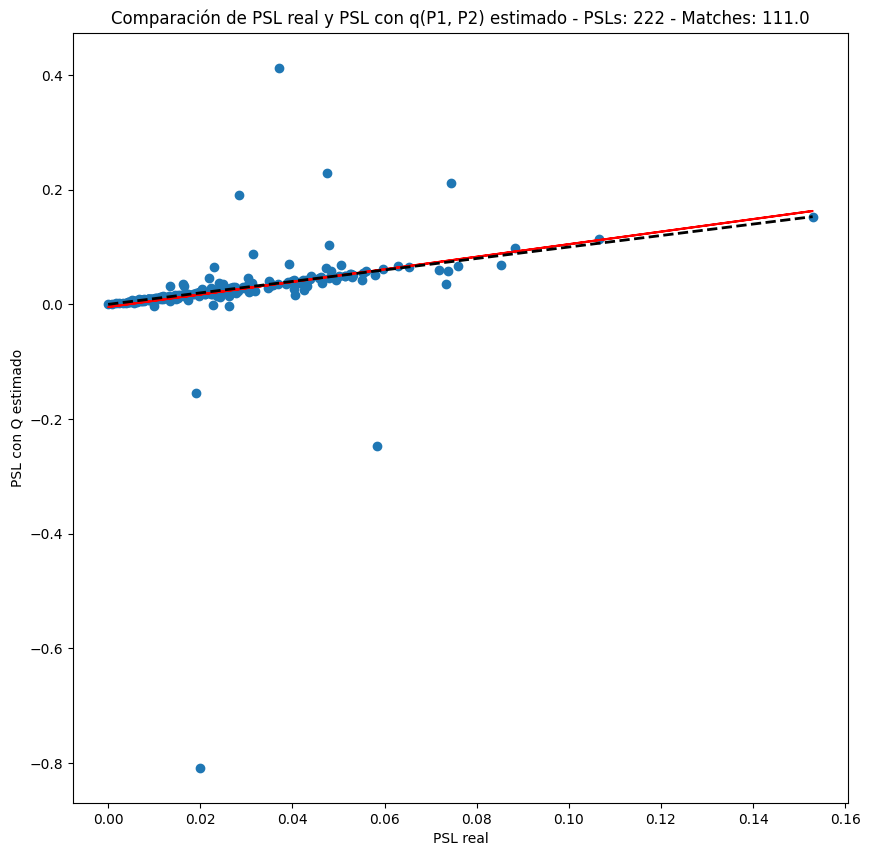

In [37]:
matches = test_matches
evaluate_psl_diffs(
    np.array(
        get_psl_diffs(R_storage, xgb_model, sample_pairs, matches, player_features_df)
    )
)

## Models

In [38]:
X_train = train_left.drop(columns=["date", "partido_id", "target", "player_1", "player_2"])
y_train = train_left["target"]

X_test = test_right.drop(columns=["date", "partido_id", "target", "player_1", "player_2"])
y_test = test_right["target"]

In [39]:
player_features_df

,,pases/90,shots/90,losses/90,gains/90,minutes,match_date
player_id,match_id,,,,,,
47412.0,442369,14.297371,2.721674,21.247992,16.164298,4321.716667,2013-05-19
43670.0,442369,51.366828,1.495929,30.105919,21.563391,3951.350000,2013-05-19
41135.0,442369,30.714391,0.363327,24.879338,29.898424,5276.566667,2013-05-19
19419.0,442369,23.366390,0.389853,15.837516,20.502915,3876.033333,2013-05-19
126184.0,442369,0.000000,0.000000,0.010747,0.000000,93.050000,2013-05-19
...,...,...,...,...,...,...,...
3289.0,442007,0.000000,0.000000,0.000000,0.000000,0.000000,2012-08-18
28147.0,442007,0.000000,0.000000,0.000000,0.000000,0.000000,2012-08-18
19575.0,442007,0.000000,0.000000,0.000000,0.000000,0.000000,2012-08-18


In [39]:

linreg = LinearRegression()

linreg.fit(np.array(X_train.values), np.array(y_train.values))

# Predecir las probabilidades en los datos de prueba
y_pred = linreg.predict(X_test)

sc = linreg.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)

display(Markdown(f"Score: {sc} - MSE: {mse}"))
diffs = np.array(
        get_psl_diffs(R_storage, linreg, sample_pairs, matches, player_features_df)
)

/Users/nacho/Desktop/code/understat-xg/.conda/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/Users/nacho/Desktop/code/understat-xg/.conda/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


Score: 0.01434355432810619 - MSE: 0.007344035129898791

 15%|█▌        | 17/111 [00:04<00:20,  4.67it/s, no_updates=0, updates=2339]

Error: La matriz es singular y no se puede invertir.
Singular matrix


 77%|███████▋  | 85/111 [00:21<00:06,  4.25it/s, no_updates=0, updates=11431]

Error: La matriz es singular y no se puede invertir.
Singular matrix


100%|██████████| 111/111 [00:28<00:00,  3.96it/s, no_updates=0, updates=14830]


(0.0, 0.3)

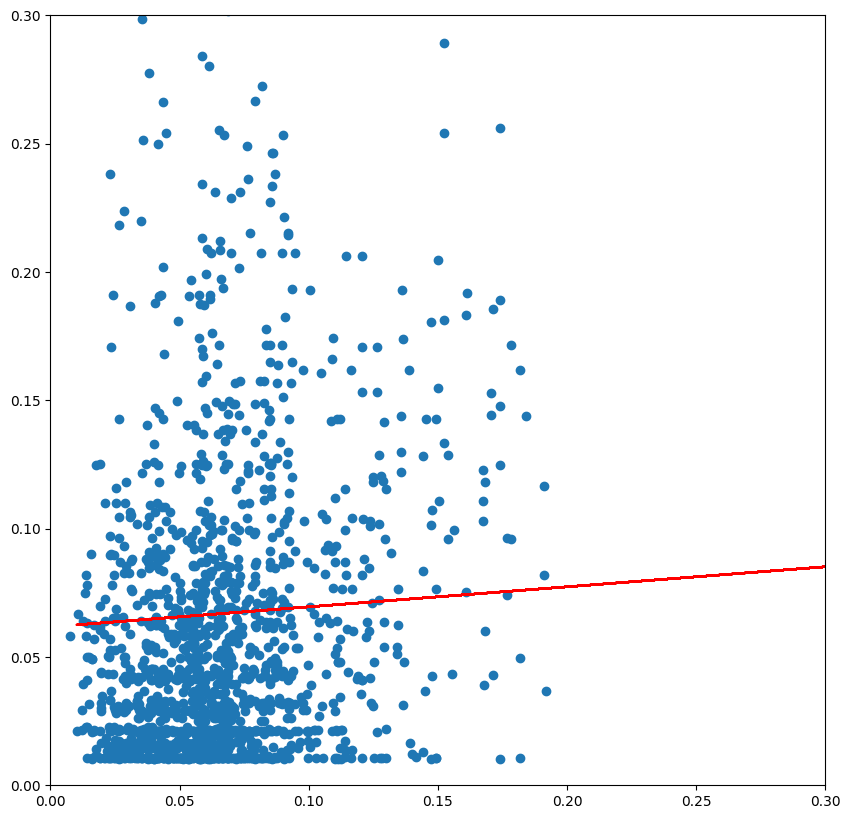

In [40]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.scatter(y_pred, y_test)

# Plot regression line
reg = LinearRegression().fit(np.array(y_test).reshape(-1, 1), y_pred)
y_pred_line = reg.predict(np.array(y_test).reshape(-1, 1))

# Dibujar la línea de regresión
ax.plot(y_test, y_pred_line, color="red", label="Línea de regresión")

ax.set_xlim(0.0, 0.3)
ax.set_ylim(0.0, 0.3)

(-0.05, 0.1)

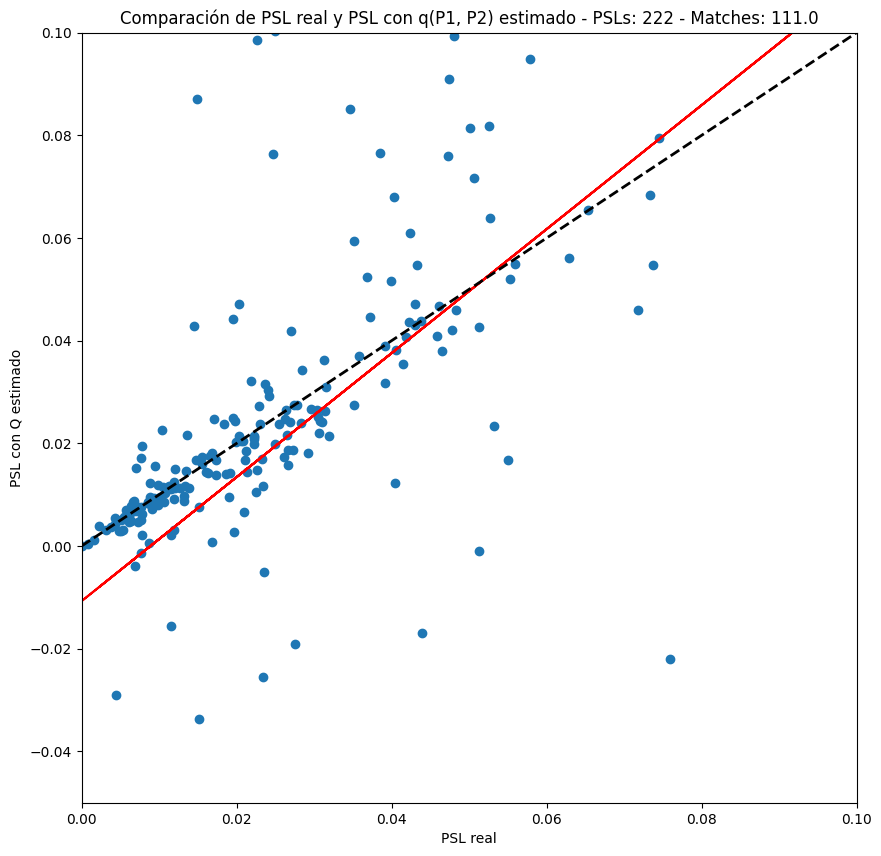

In [41]:

fig, ax = plt.subplots(figsize=(10, 10))

evaluate_psl_diffs(
    diffs,
    ax=ax,
)

ax.set_xlim(-0.0, 0.1)
ax.set_ylim(-0.05, 0.1)

<Axes: >

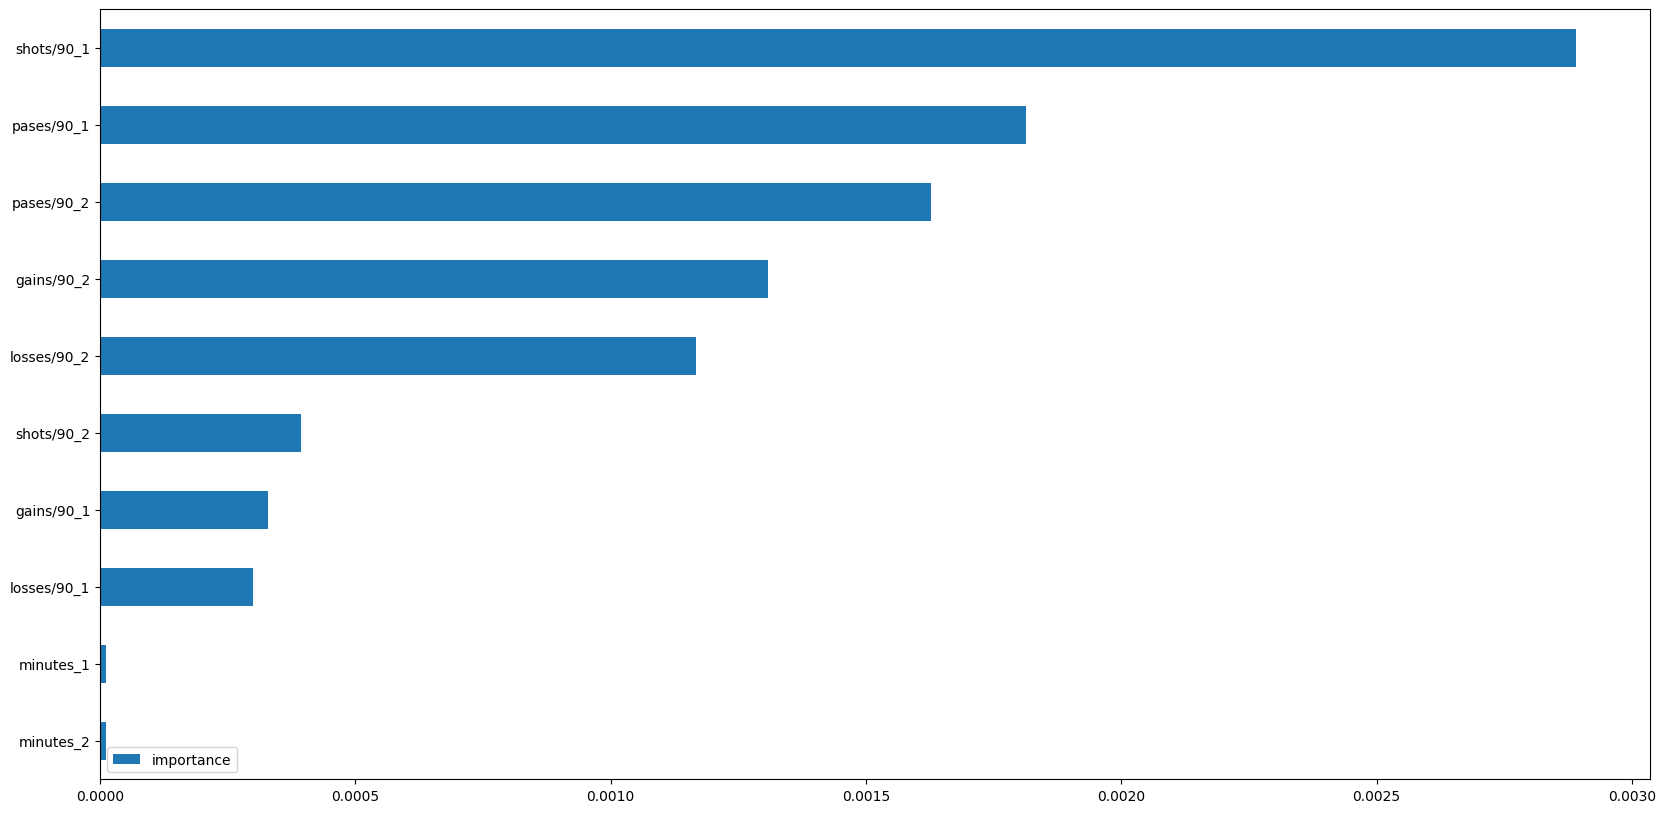

In [42]:
# Feature importance

# Plot linreg betas

importance = pd.DataFrame(linreg.coef_, index=X_train.columns, columns=["importance"])
importance = abs(importance).sort_values(by="importance")

fig, ax = plt.subplots(figsize=(20, 10))

importance.plot(kind="barh", ax=ax)

In [76]:
# Make a Dumb Model

class DumbModel:
    def __init__(self):
        pass

    def fit(self, X, y):
        pass

    def predict(self, X):
        return np.random.rand(X.shape[0])
        # return np.zeros(X.shape[0])
    
    def score(self, X, y):
        return 0
    

 15%|█▌        | 17/111 [00:02<00:10,  8.64it/s, no_updates=1222, updates=777]

Error: La matriz es singular y no se puede invertir.
Singular matrix
Error: La matriz es singular y no se puede invertir.
Singular matrix


 77%|███████▋  | 86/111 [00:13<00:03,  6.55it/s, no_updates=6427, updates=4190]

Error: La matriz es singular y no se puede invertir.
Singular matrix
Error: La matriz es singular y no se puede invertir.
Singular matrix


100%|██████████| 111/111 [00:17<00:00,  6.51it/s, no_updates=8099, updates=5493]


(np.float64(0.9623601346401868),
 np.float64(-0.0004181096351145823),
 np.float64(1.0939926902667106e-05))

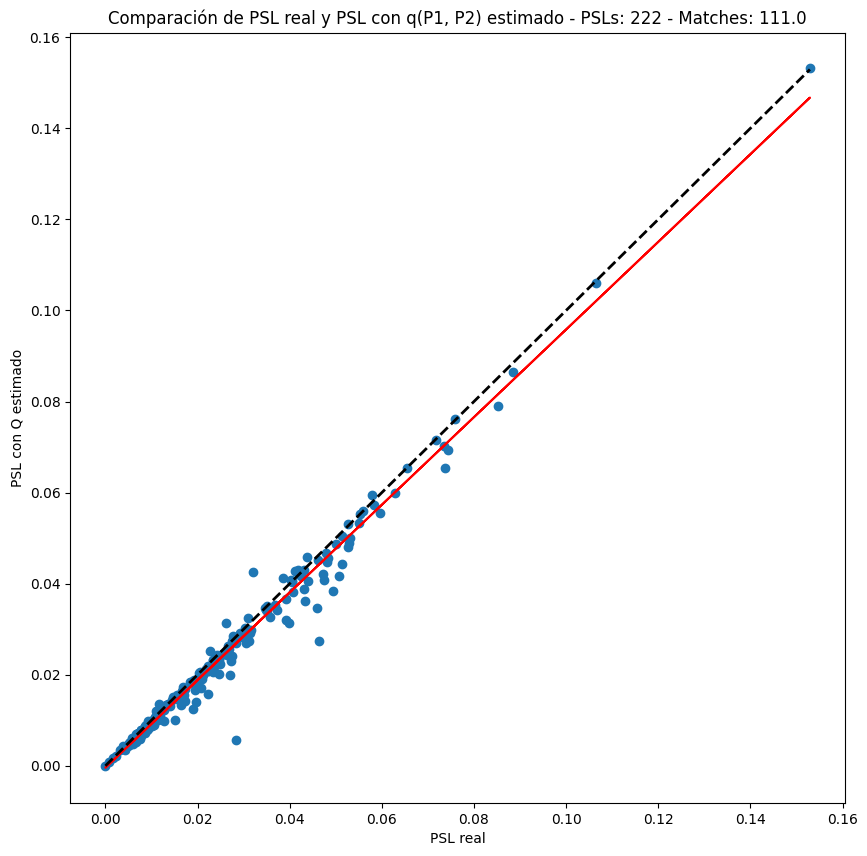

In [72]:
dumb_model = DumbModel()

evaluate_psl_diffs(
    np.array(
        get_psl_diffs(R_storage, dumb_model, sample_pairs, matches, player_features_df)
    )
)

In [68]:
X_train.columns

Index(['pases/90_1', 'shots/90_1', 'losses/90_1', 'gains/90_1', 'minutes_1',
       'pases/90_2', 'shots/90_2', 'losses/90_2', 'gains/90_2', 'minutes_2'],
      dtype='object')

Score: -0.02001667016752684 - MSE: 0.0053422353189042345

100%|██████████| 111/111 [00:16<00:00,  6.58it/s]


(np.float64(0.9593910329028492),
 np.float64(0.0013512577576633988),
 np.float64(6.471570986502091e-05))

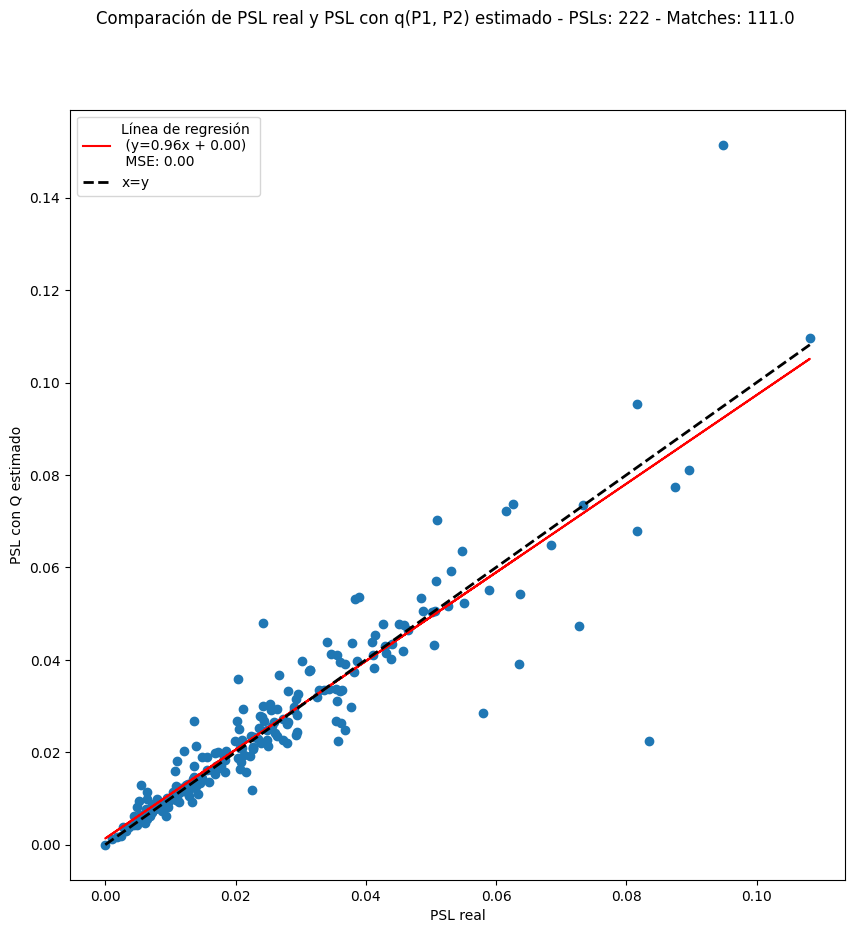

In [360]:
# Linear Regression with less columns, only passes

sub_model_cols = ["pases/90_1", "pases/90_2"]
X_train_passes = X_train[sub_model_cols]

linreg_passes = LinearRegression()

linreg_passes.fit(np.array(X_train_passes.values), np.array(y_train.values))

# Predecir las probabilidades en los datos de prueba
y_pred = linreg_passes.predict(X_test[sub_model_cols])

sc = linreg_passes.score(X_test[sub_model_cols], y_test)
mse = mean_squared_error(y_test, y_pred)

display(Markdown(f"Score: {sc} - MSE: {mse}"))

evaluate_psl_diffs(
    np.array(
        get_psl_diffs(
            R_storage, linreg_passes, sample_pairs, matches, player_features_df, list(set([col[:-2] for col in X_train_passes.columns]))
        )
    )
)

<Axes: >

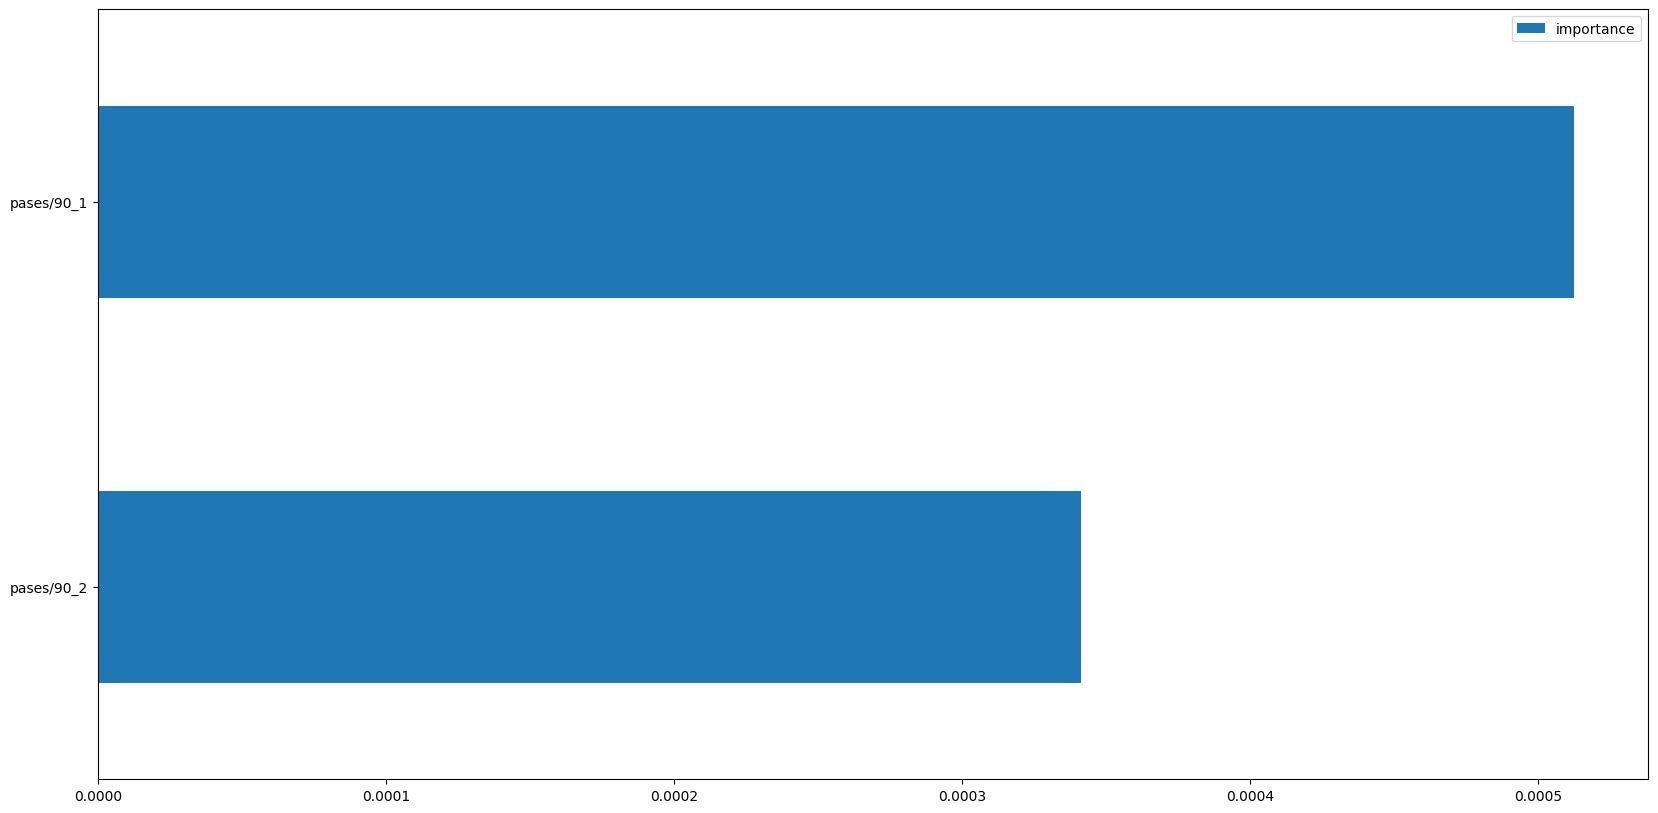

In [362]:
importance = pd.DataFrame(
    linreg_passes.coef_, index=X_train_passes.columns, columns=["importance"]
)
importance = importance.sort_values(by="importance")

fig, ax = plt.subplots(figsize=(20, 10))

importance.plot(kind="barh", ax=ax)

/Users/nacho/Desktop/code/understat-xg/.conda/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/Users/nacho/Desktop/code/understat-xg/.conda/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


Score: -0.0026368212350458275 - MSE: 0.007391480434842096

 16%|█▌        | 18/111 [00:04<00:21,  4.29it/s, no_updates=0, updates=2697]

Error: La matriz es singular y no se puede invertir.
Singular matrix


 77%|███████▋  | 86/111 [00:21<00:04,  5.53it/s, no_updates=0, updates=13141]

Error: La matriz es singular y no se puede invertir.
Singular matrix


100%|██████████| 111/111 [00:27<00:00,  4.08it/s, no_updates=0, updates=17304]


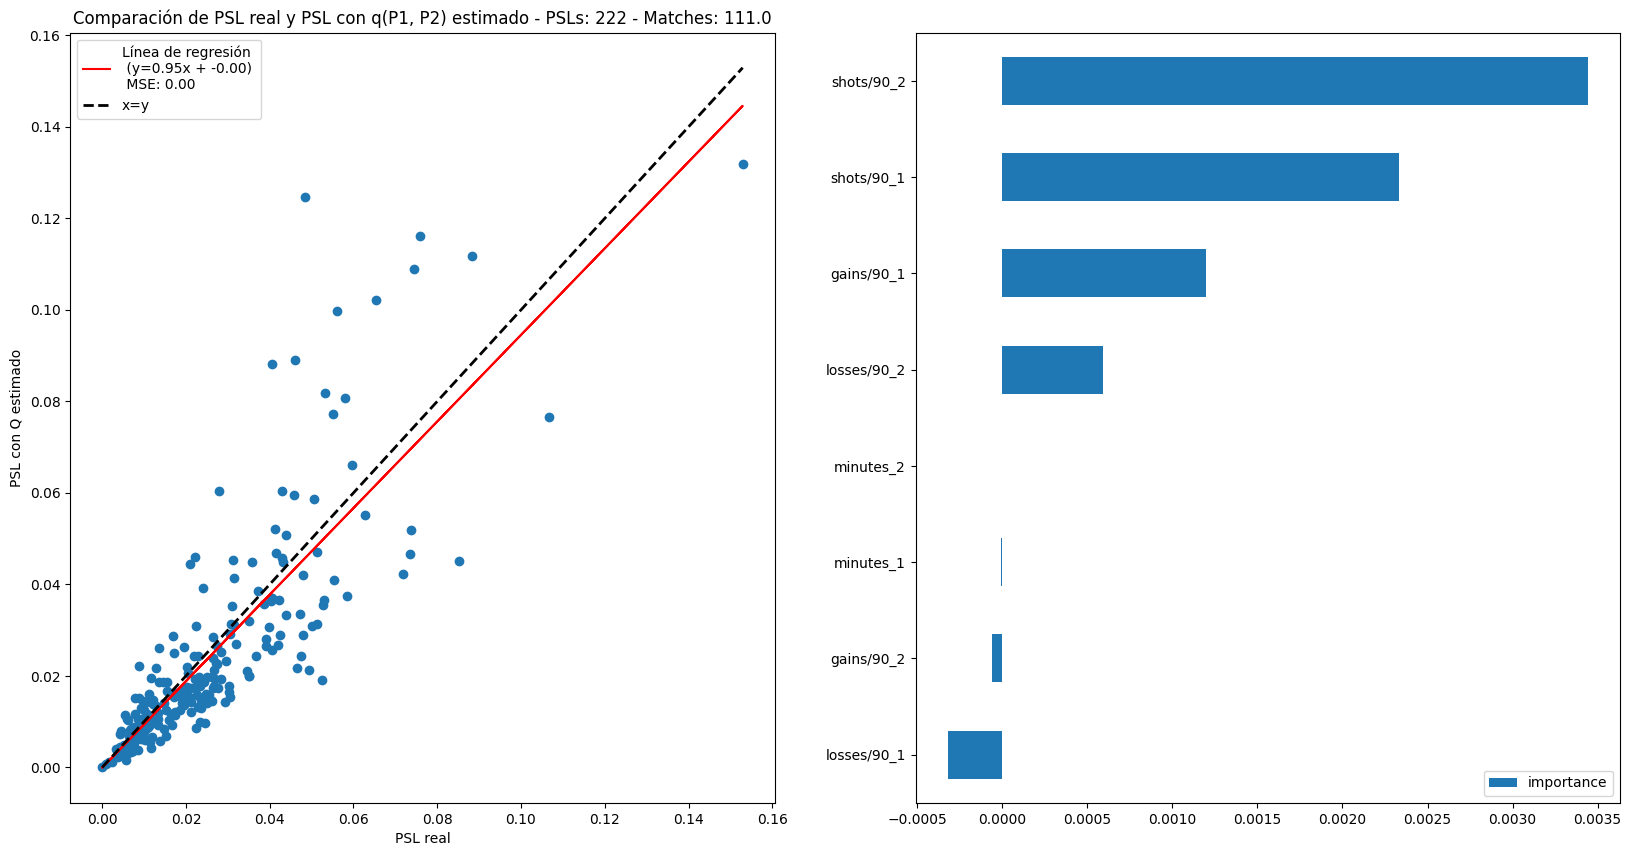

In [44]:
# Withouth passes

sub_model_cols = X_train.columns.difference(["pases/90_1", "pases/90_2"])

X_train_no_passes = X_train[sub_model_cols]

linreg_no_passes = LinearRegression()

linreg_no_passes.fit(np.array(X_train_no_passes.values), np.array(y_train.values))

# Predecir las probabilidades en los datos de prueba
y_pred = linreg_no_passes.predict(X_test[sub_model_cols])
sc = linreg_no_passes.score(X_test[sub_model_cols], y_test)
mse = mean_squared_error(y_test, y_pred)
display(Markdown(f"Score: {sc} - MSE: {mse}"))

fig, axs = plt.subplots(1, 2, figsize=(20, 10))

importance = pd.DataFrame(
    linreg_no_passes.coef_, index=X_train_no_passes.columns, columns=["importance"]
).sort_values(by="importance")


evaluate_psl_diffs(
    np.array(
        get_psl_diffs(
            R_storage, linreg_no_passes, sample_pairs, matches, player_features_df, list(set([col[:-2] for col in X_train_no_passes.columns]))
        )
    ),
    ax=axs[0],
)

importance.plot(kind="barh", ax=axs[1])

axs[0].legend()

In [59]:
def train_model(model, X_train, y_train, X_test, y_test, R_storage, sample_pairs, matches, player_features_df, ax=None):
    model.fit(np.array(X_train.values), np.array(y_train.values))

    # Predecir las probabilidades en los datos de prueba
    y_pred = model.predict(X_test)

    sc = model.score(X_test, y_test)
    q_mse = mean_squared_error(y_test, y_pred)

    display(Markdown(f"Score: {sc} - MSE: {q_mse}"))

    return model, y_pred, sc, q_mse

# Train the model with only passes of the player 1

sub_model_cols = ["pases/90_1", "pases/90_2"]
X_train_passes_1 = X_train[sub_model_cols]
X_train_passes_1["pases/90_2"] = 0
linreg_passes_1 = LinearRegression()

def model_info(model, X_train, y_train, X_test, y_test, R_storage, sample_pairs, matches, player_features_df, cols=None):

    fig, axs = plt.subplots(1, 3, figsize=(20, 10))

    model, y_pred, sc, q_mse = train_model(
        model,
        X_train,
        y_train,
        X_test,
        y_test,
        R_storage,
        sample_pairs,
        matches,
        player_features_df,
    )

    psl_slope, psl_intercept, psl_mse = evaluate_psl_diffs(
        np.array(
            get_psl_diffs(
                R_storage,
                model,
                sample_pairs,
                matches,
                player_features_df,
                model_cols=list(set([col[:-2] for col in X_train.columns])) if cols is None else cols,
            )
        ),
        ax=axs[1],
    )

    axs[1].legend()

    axs[0].scatter(y_test, y_pred)

    # Regresión lineal para los datos, comparar la pendiente con y=x
    reg = LinearRegression().fit(y_test.values.reshape(-1, 1), y_pred)
    y_pred_line = reg.predict(y_test.values.reshape(-1, 1))

    # Obtener la pendiente (slope) y la intersección (intercept)
    q_slope = reg.coef_[0]
    q_intercept = reg.intercept_

    axs[0].plot(
        y_test, y_pred_line, color="red", label=f"Línea de regresión \n (y={q_slope:.2f}x + {q_intercept:.2f})"
    )

    # Plot y=x for the range of the data
    axs[0].plot([y_test.min(), y_test.max()], [y_pred.min(), y_pred.max()], "k--")

    axs[0].set_xlabel("q real")
    axs[0].set_ylabel("q estimada")
    axs[0].set_title("Comparación de q estimada vs q real")

    axs[0].legend()

    if hasattr(model, "coef_"):
        _ = (
            pd.DataFrame(
                model.coef_, index=X_train.columns, columns=["importance"]
            )
            .sort_values(by="importance")
            .plot(kind="barh", ax=axs[2])
        )
    # If model is xgb
    if isinstance(model, xgb.XGBRegressor):
        pd.DataFrame(
            model.feature_importances_, index=X_train.columns, columns=["importance"]
        ).sort_values(by="importance").plot(kind="barh", ax=axs[2])

    axs[2].set_title("Importancia de las variables")

    # for i in range(3):
    # axs[i].set_title(f"Modelo: {model.__class__.__name__}")

    axs[1].set_xlim(0, 0.2)
    axs[1].set_ylim(0, 0.2)

    fig.suptitle(f"Modelo: {model.__class__.__name__}")

    return model, y_pred, sc, q_mse, psl_slope, psl_intercept, psl_mse

/var/folders/5j/7b3w3dw95qdcll87vxc3yn300000gn/T/ipykernel_53898/1010418894.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_passes_1["pases/90_2"] = 0


/Users/nacho/Desktop/code/understat-xg/.conda/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/Users/nacho/Desktop/code/understat-xg/.conda/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


Score: 0.01434355432810619 - MSE: 0.007344035129898791

 15%|█▌        | 17/111 [00:04<00:19,  4.94it/s, no_updates=0, updates=2345]

Error: La matriz es singular y no se puede invertir.
Singular matrix


 77%|███████▋  | 85/111 [00:19<00:04,  5.42it/s, no_updates=0, updates=11431]

Error: La matriz es singular y no se puede invertir.
Singular matrix


100%|██████████| 111/111 [00:25<00:00,  4.28it/s, no_updates=0, updates=14830]


(LinearRegression(),
 array([0.06067874, 0.07678237, 0.07678237, ..., 0.0253366 , 0.03032386,
        0.06150957]),
 0.01434355432810619,
 np.float64(0.007344035129898791),
 np.float64(1.2076142587645395),
 np.float64(-0.01073290644925498),
 np.float64(0.008387602310634347))

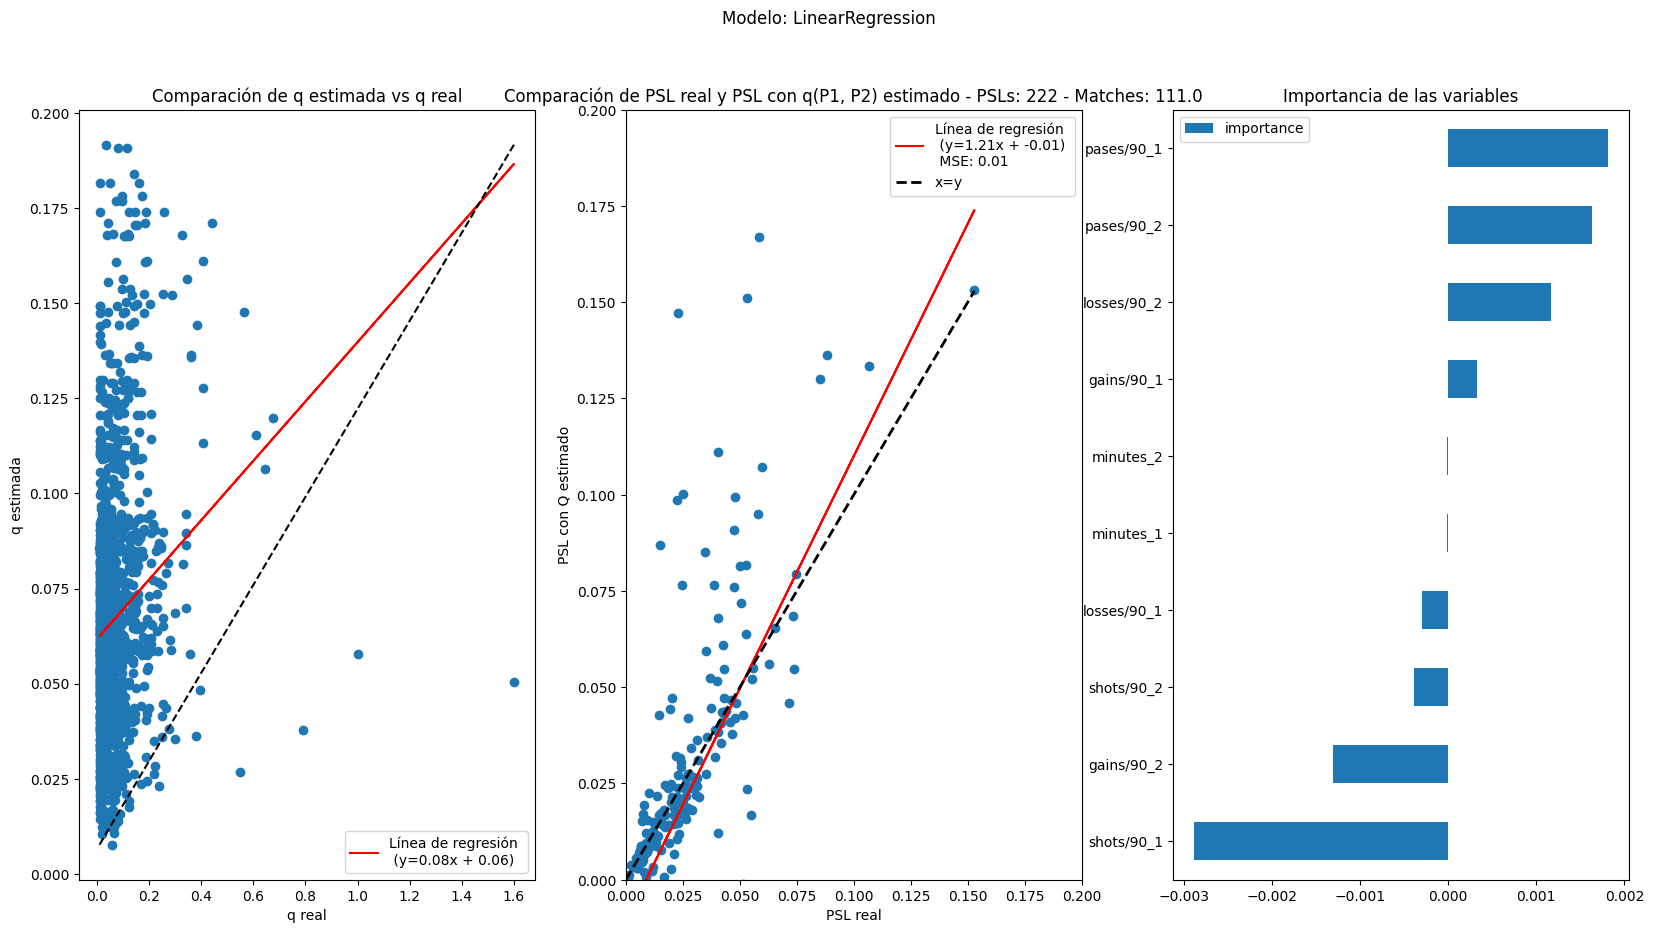

In [53]:
model_info(
    linreg,
    X_train,
    y_train,
    X_test,
    y_test,
    R_storage,
    sample_pairs,
    matches,
    player_features_df,
)

In [54]:
model_info(
    DumbModel(),
    X_train,
    y_train,
    X_test,
    y_test,
    R_storage,
    sample_pairs,
    matches,
    player_features_df,
)

NameError: name 'DumbModel' is not defined

/Users/nacho/Desktop/code/understat-xg/.conda/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/Users/nacho/Desktop/code/understat-xg/.conda/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


Score: 0.014355249757043165 - MSE: 0.007343947988338108

 15%|█▌        | 17/111 [00:04<00:24,  3.91it/s, no_updates=0, updates=2345]

Error: La matriz es singular y no se puede invertir.
Singular matrix


 77%|███████▋  | 85/111 [00:23<00:04,  5.58it/s, no_updates=7, updates=11514]

Error: La matriz es singular y no se puede invertir.
Singular matrix


100%|██████████| 111/111 [00:28<00:00,  3.85it/s, no_updates=11, updates=14819]


(LinearRegression(),
 array([0.0743755 , 0.08835107, 0.08835107, ..., 0.07887999, 0.0790471 ,
        0.08215015]),
 0.014355249757043165,
 np.float64(0.007343947988338108),
 np.float64(0.988708381232065),
 np.float64(0.00019536411770024534),
 np.float64(5.7636018340532765e-06))

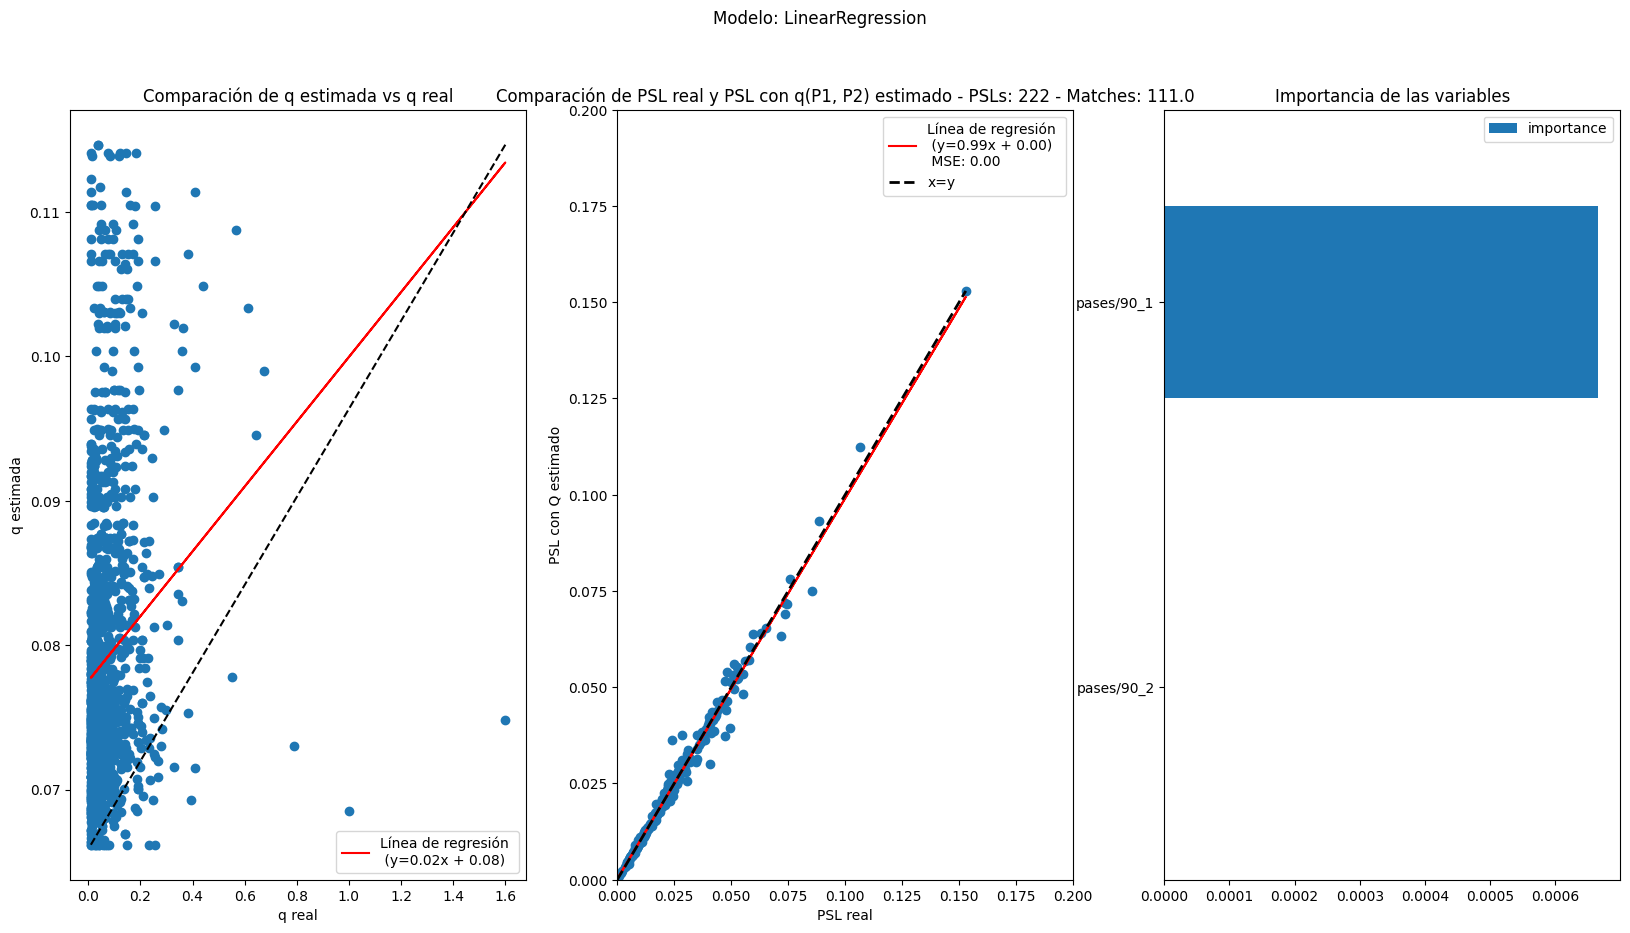

In [55]:
model_info(
    linreg_passes_1,
    X_train_passes_1,
    y_train,
    X_test[X_train_passes_1.columns],
    y_test,
    R_storage,
    sample_pairs,
    matches,
    player_features_df,
)

Score: -0.061895572020015166 - MSE: 0.007912085817977765

 15%|█▌        | 17/111 [00:06<00:31,  3.02it/s, no_updates=0, updates=2239]

Error: La matriz es singular y no se puede invertir.
Singular matrix


 77%|███████▋  | 85/111 [00:33<00:07,  3.32it/s, no_updates=0, updates=11431]

Error: La matriz es singular y no se puede invertir.
Singular matrix


100%|██████████| 111/111 [00:43<00:00,  2.52it/s, no_updates=0, updates=14830]


(XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...),
 array([0.03806947, 0.07103145, 0.07103145, ..., 0.07321923, 0.07643322,
        0.07705478], dtype=float32),
 -0.061895572020015166,
 np.float64(0.007912085817977765),
 np.float64(1.2200634327415103),
 np.float64(-0.0016215745689981305),
 n

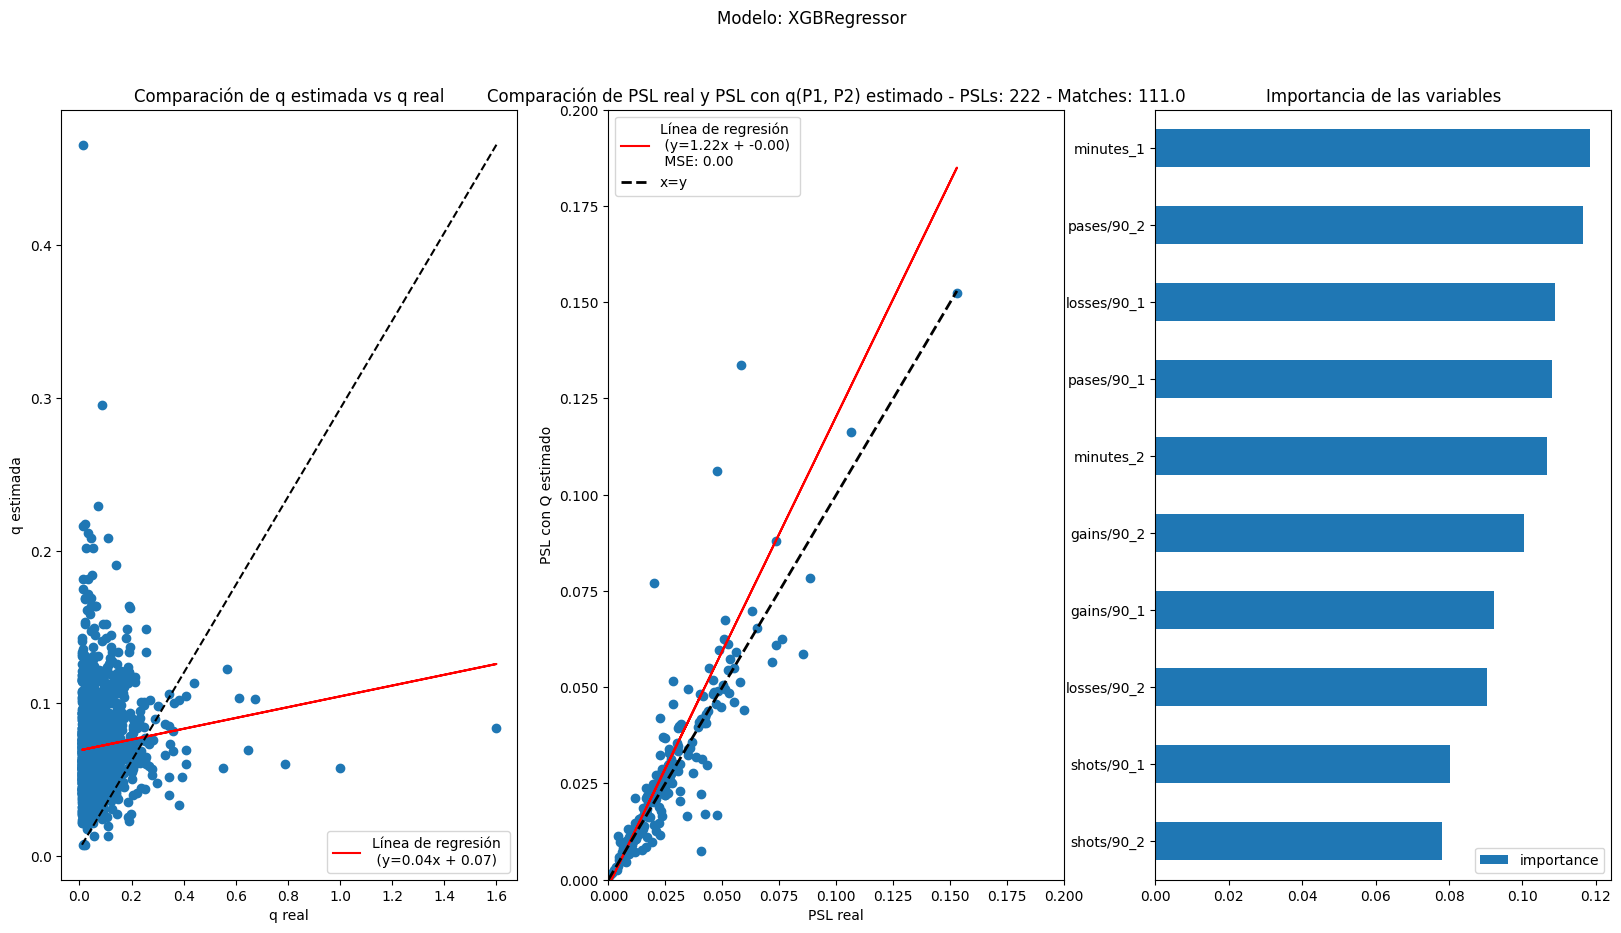

In [56]:
model_info(
    xgb_model,
    X_train,
    y_train,
    X_test,
    y_test,
    R_storage,
    sample_pairs,
    matches,
    player_features_df,
)

Score: -0.06288682515264266 - MSE: 0.00783564597487035

 15%|█▌        | 17/111 [00:05<00:26,  3.51it/s, no_updates=0, updates=2697]

Error: La matriz es singular y no se puede invertir.
Singular matrix


 77%|███████▋  | 85/111 [00:25<00:07,  3.49it/s, no_updates=0, updates=13003]

Error: La matriz es singular y no se puede invertir.
Singular matrix


100%|██████████| 111/111 [00:34<00:00,  3.25it/s, no_updates=0, updates=17304]


(XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...),
 array([0.04891885, 0.03853185, 0.06758728, ..., 0.09340093, 0.06065712,
        0.0590083 ], dtype=float32),
 -0.06288682515264266,
 np.float64(0.00783564597487035),
 np.float64(1.03140457261057),
 np.float64(0.00021299943348116607),
 np.fl

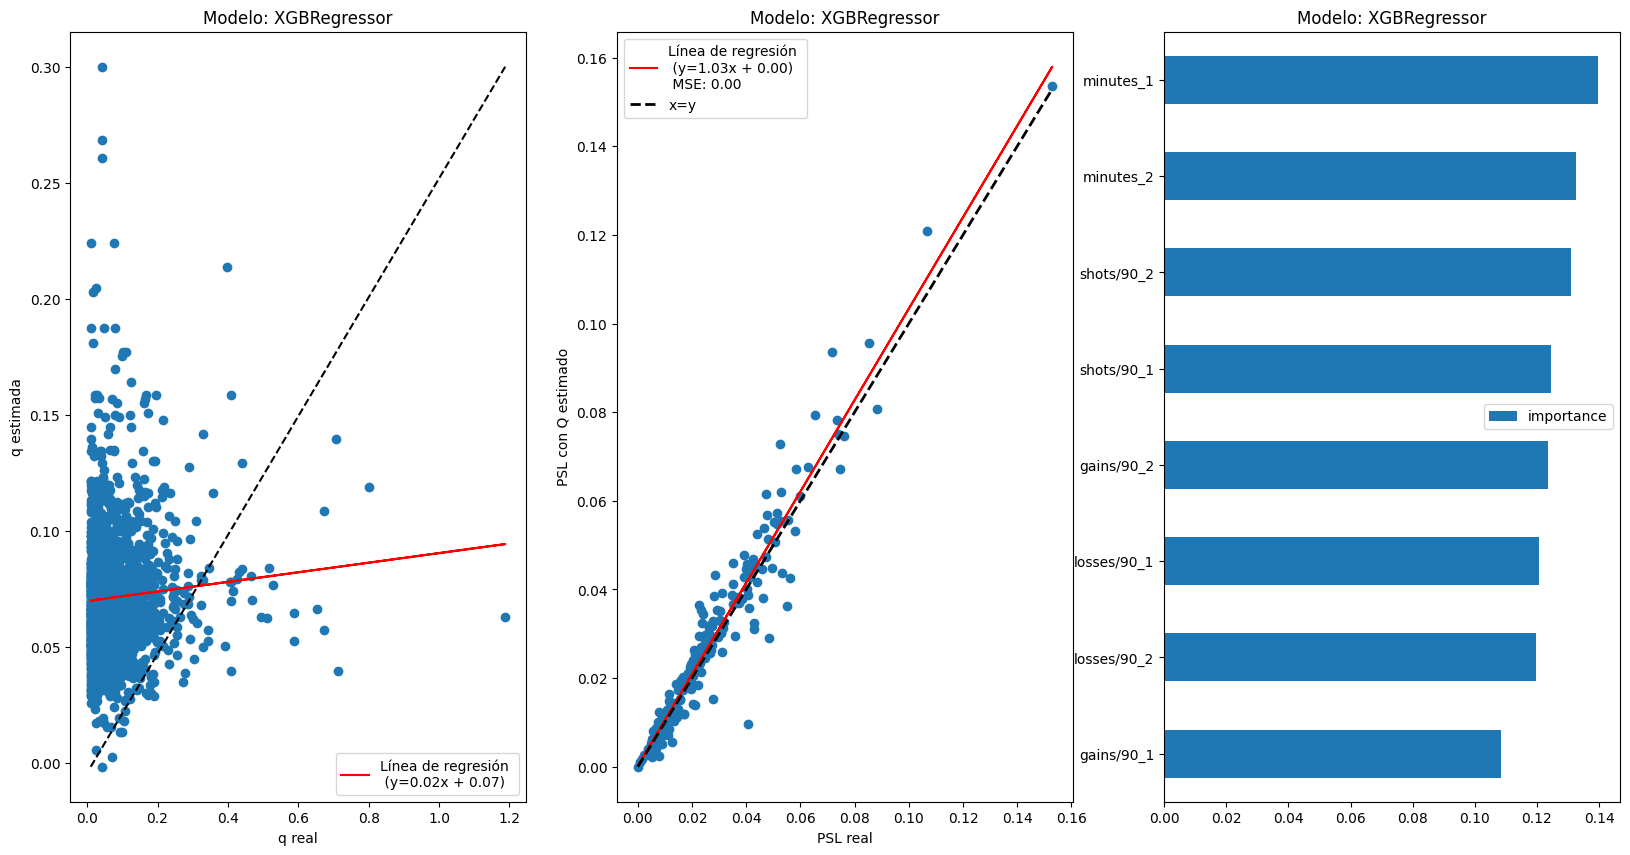

In [50]:
no_passes_cols = X_train.columns.difference(["pases/90_1", "pases/90_2"])
model_info(
    xgb.XGBRegressor(),
    X_train[no_passes_cols],
    y_train,
    X_test[no_passes_cols],
    y_test,
    R_storage,
    sample_pairs,
    matches,
    player_features_df,
)

Score: -0.17860807883345853 - MSE: 0.009711784815760474

100%|██████████| 11/11 [00:04<00:00,  2.21it/s, no_updates=0, updates=2080]


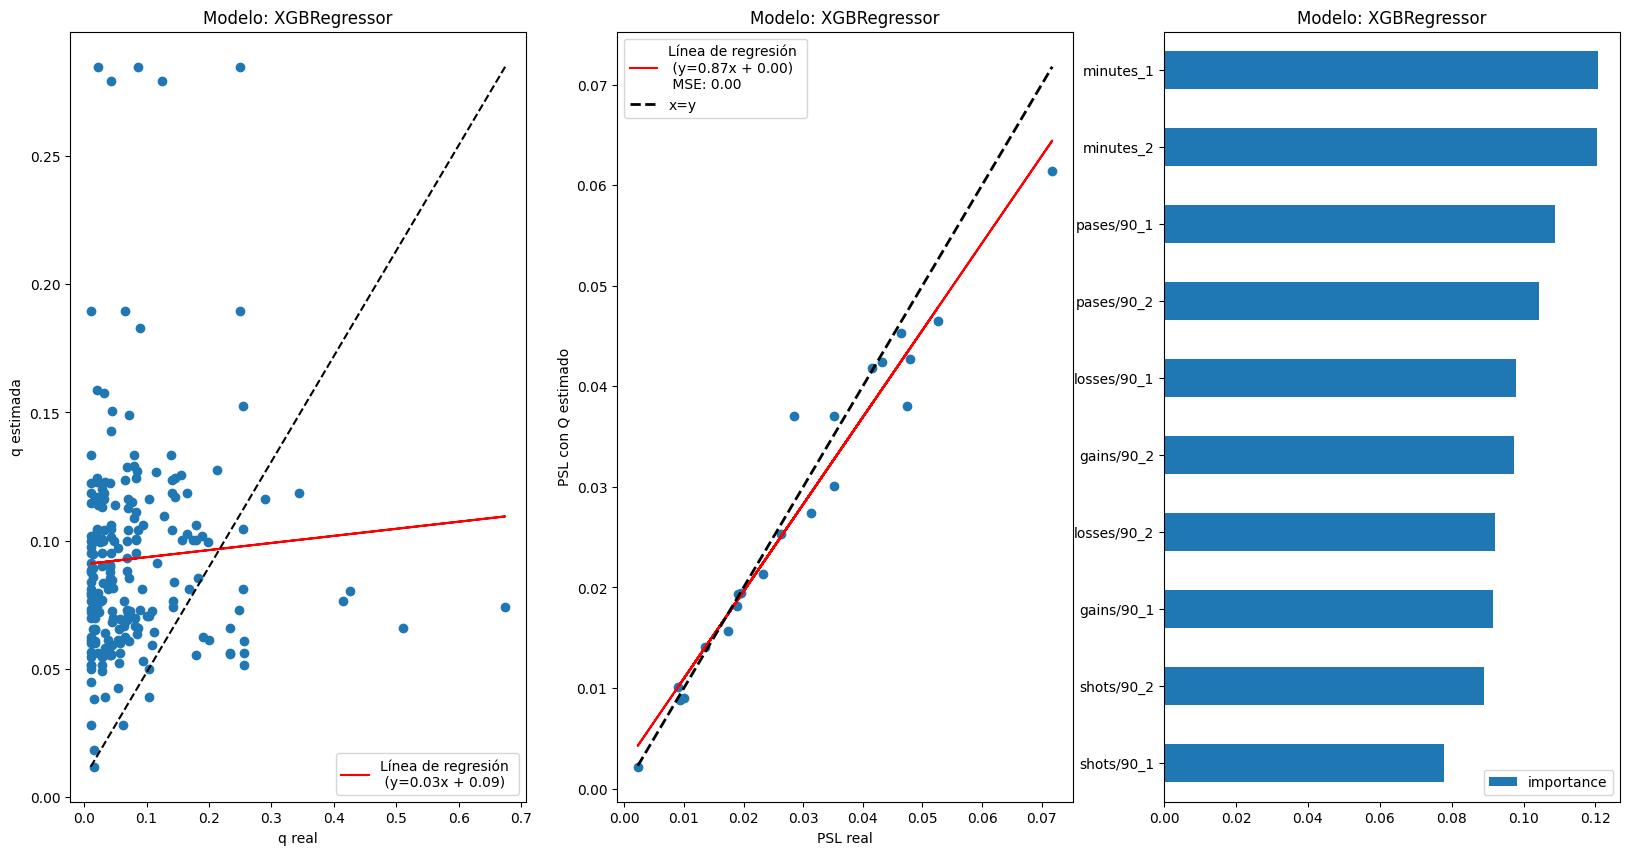

In [51]:
# Remove a whole team from train
# Manchester City
mancity_id = epl[epl["home_team_name"] == "Manchester City"]["home_team_id"].values[0]
mancity_id

mancity_matches_id = epl[
    (epl["home_team_id"] == mancity_id) | (epl["away_team_id"] == mancity_id)
]["match_id"]

X_train_no_mancity = train_left[
    ~train_left["partido_id"].isin(mancity_matches_id)
].drop(columns=["player_1", "player_2", "target", "date", "partido_id"])

y_train_no_mancity = train_left[
    ~train_left["partido_id"].isin(mancity_matches_id)
]["target"]

X_test_only_mancity = test_right[
    test_right["partido_id"].isin(mancity_matches_id)
].drop(columns=["player_1", "player_2", "target", "date", "partido_id"])

y_test_only_mancity = test_right[
    test_right["partido_id"].isin(mancity_matches_id)
]["target"]

mancity_matches = matches[matches["match_id"].isin(mancity_matches_id)]

# sub_R_storage = R_storage[mancity_matches.index]

_ = model_info(
    xgb.XGBRegressor(),
    X_train_no_mancity,
    y_train_no_mancity,
    X_test_only_mancity,
    y_test_only_mancity,
    R_storage,
    sample_pairs,
    mancity_matches,
    player_features_df,
)

Score: -0.03537520939028216 - MSE: 0.008256305198796268

 16%|█▌        | 14/87 [00:04<00:20,  3.59it/s, no_updates=0, updates=2301]

Error: La matriz es singular y no se puede invertir.
Singular matrix


100%|██████████| 87/87 [00:26<00:00,  3.29it/s, no_updates=0, updates=13693]


(XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...),
 array([0.04568362, 0.04939146, 0.07618807, ..., 0.05985119, 0.08738717,
        0.04178811], dtype=float32),
 -0.03537520939028216,
 np.float64(0.008256305198796268),
 np.float64(0.9970757076830926),
 np.float64(0.00015798681614779403),
 np

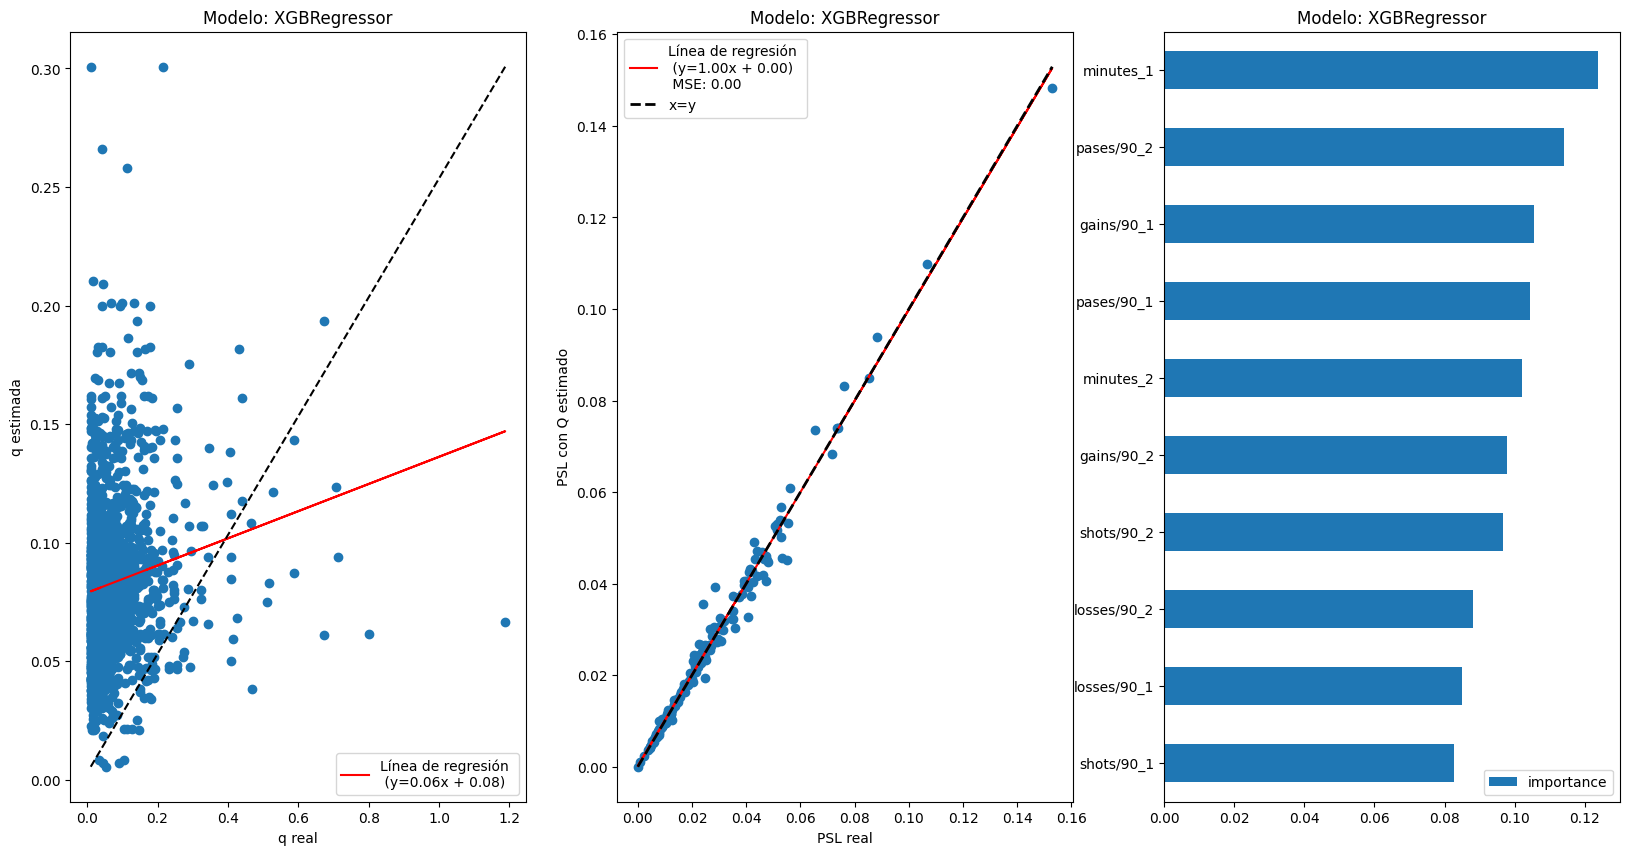

In [52]:
# Remove half of the teams from train

team_ids = epl["home_team_id"].unique()

np.random.seed(42)
np.random.shuffle(team_ids)

half_teams = team_ids[: int(len(team_ids) / 2)]
half_teams_matches = matches[
    matches["home_team_id"].isin(half_teams) | matches["away_team_id"].isin(half_teams)
]

half_teams_matches_id = half_teams_matches["match_id"]

X_train_no_half_teams = train_left[
    ~train_left["partido_id"].isin(half_teams_matches_id)
].drop(columns=["player_1", "player_2", "target", "date", "partido_id"])

y_train_no_half_teams = train_left[
    ~train_left["partido_id"].isin(half_teams_matches_id)
]["target"]

X_test_only_half_teams = test_right[
    test_right["partido_id"].isin(half_teams_matches_id)
].drop(columns=["player_1", "player_2", "target", "date", "partido_id"])

y_test_only_half_teams = test_right[
    test_right["partido_id"].isin(half_teams_matches_id)
]["target"]

model_info(
    xgb.XGBRegressor(),
    X_train_no_half_teams,
    y_train_no_half_teams,
    X_test_only_half_teams,
    y_test_only_half_teams,
    R_storage,
    sample_pairs,
    half_teams_matches,
    player_features_df,
)

Error: La matriz es singular y no se puede invertir.
Singular matrix
Error: La matriz es singular y no se puede invertir.
Singular matrix
Error: La matriz es singular y no se puede invertir.
Singular matrix
Error: La matriz es singular y no se puede invertir.
Singular matrix
Error: La matriz es singular y no se puede invertir.
Singular matrix
Error: La matriz es singular y no se puede invertir.
Singular matrix
Error: La matriz es singular y no se puede invertir.
Singular matrix
Error: La matriz es singular y no se puede invertir.
Singular matrix
Error: La matriz es singular y no se puede invertir.
Singular matrix
Error: La matriz es singular y no se puede invertir.
Singular matrix
Error: La matriz es singular y no se puede invertir.
Singular matrix
Error: La matriz es singular y no se puede invertir.
Singular matrix
Error: La matriz es singular y no se puede invertir.
Singular matrix
Error: La matriz es singular y no se puede invertir.
Singular matrix
Error: La matriz es singular y no 

Text(0.5, 1.0, 'MSE over amount of destruction')

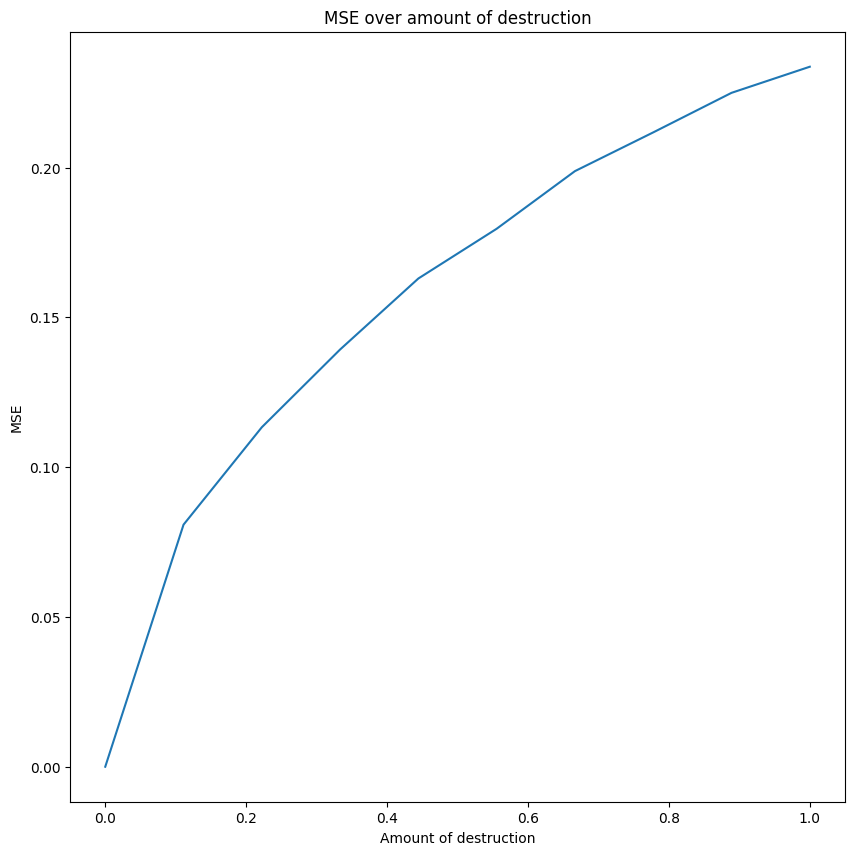

In [489]:
# Gradually destroy the R matrix, compute Q and PSL, and compare with the real PSL, MSE

def destroy_R(R, amount):
    # Destroy the R matrix by setting the amount of values to 0
    # Destroy the values in the diagonal
    # Return the destroyed R matrix

    R = R.copy()
    
    R = (np.random.rand(*R.shape) * amount) + (R * (1 - amount))

    return R

mse_over_amms = []

for amm in np.linspace(0, 1, 10):
    psl_diffs = []

    for i in range(R_storage.shape[0]):
        for j in range(R_storage.shape[1]):
            for k in range(R_storage.shape[2]):
                R = R_storage[i, j, k].copy()[1:, 1:]
                real_psl = psl_estimator(build_Q(R))

                mod_psl = psl_estimator(build_Q(destroy_R(R, amm)))

                psl_diffs.append((real_psl, mod_psl))

    psl_diffs_arr = np.array(psl_diffs)

    slope, intercept, mse = evaluate_psl_diffs(psl_diffs_arr, plot=False)

    mse_over_amms.append((amm, mse))

mse_over_amms = np.array(mse_over_amms)

fig, ax = plt.subplots(figsize=(10, 10))

ax.plot(mse_over_amms[:, 0], mse_over_amms[:, 1])

ax.set_xlabel("Amount of destruction")
ax.set_ylabel("MSE")
ax.set_title("MSE over amount of destruction")


Score: -0.015132720668338706 - MSE: 0.007563660132122444

 15%|█▌        | 17/111 [00:06<00:28,  3.29it/s, no_updates=0, updates=2239]

Error: La matriz es singular y no se puede invertir.
Singular matrix


 77%|███████▋  | 85/111 [00:32<00:07,  3.44it/s, no_updates=0, updates=11431]

Error: La matriz es singular y no se puede invertir.
Singular matrix


100%|██████████| 111/111 [00:41<00:00,  2.69it/s, no_updates=0, updates=14830]


(XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...),
 array([0.06694223, 0.06717695, 0.06717695, ..., 0.07696557, 0.07173399,
        0.09961136], dtype=float32),
 -0.015132720668338706,
 np.float64(0.007563660132122444),
 np.float64(0.9611132000276332),
 np.float64(0.0010128706678289232),
 np

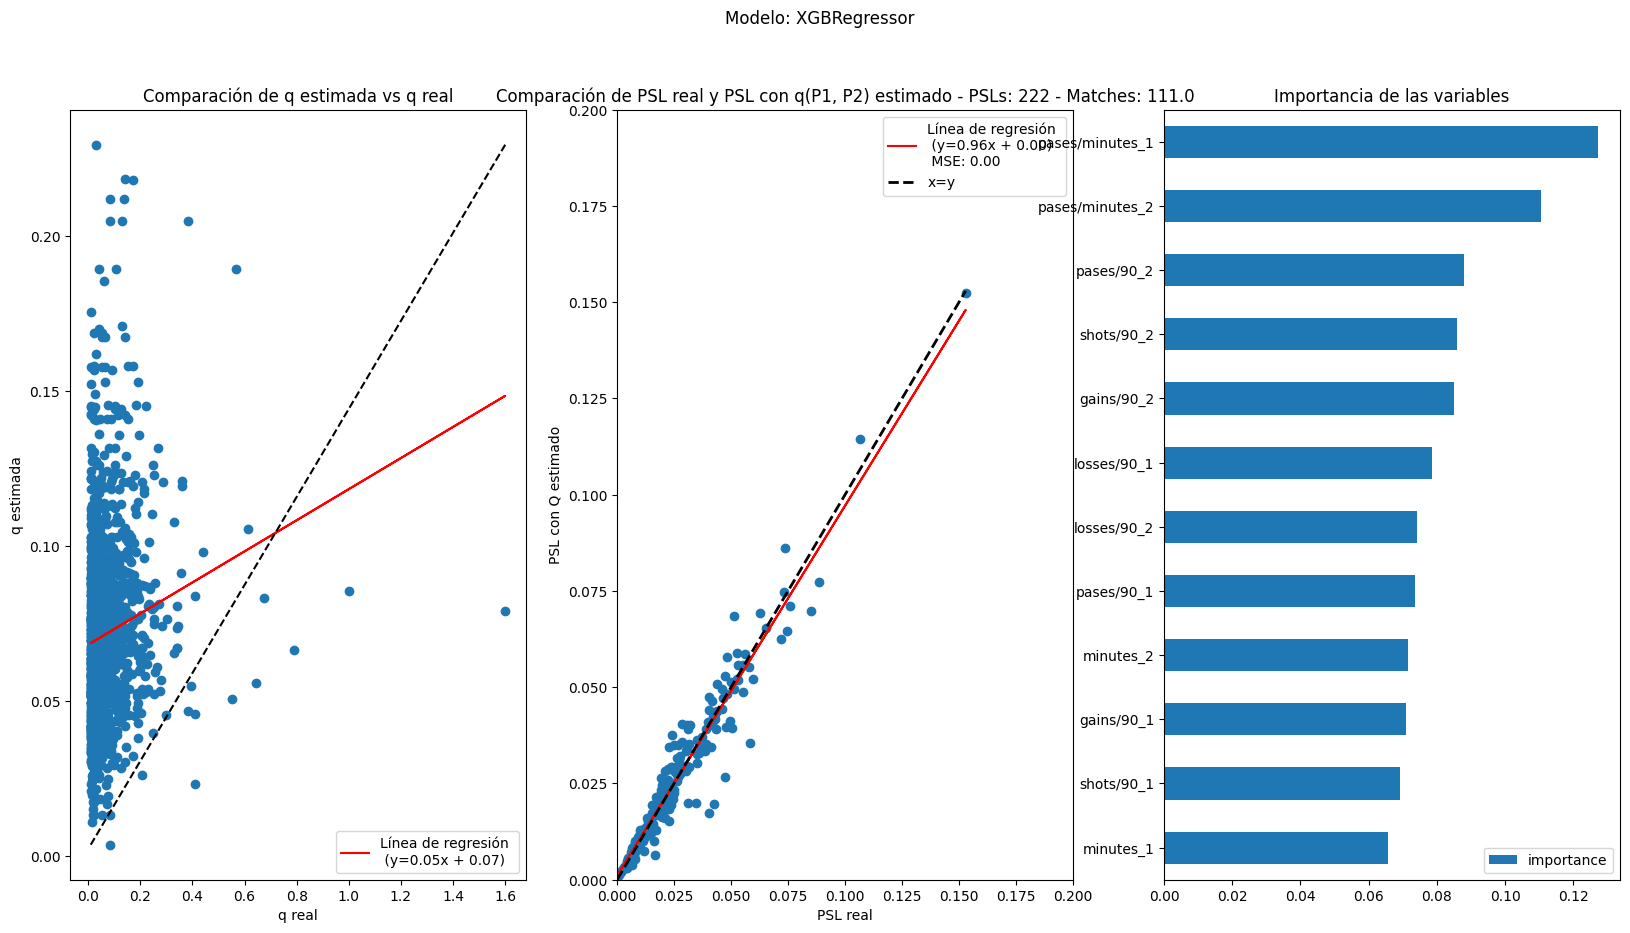

In [74]:
# Feature Engineering

X_train["pases/minutes_1"] = X_train["pases/90_1"] / X_train["minutes_1"]
X_train["pases/minutes_2"] = X_train["pases/90_2"] / X_train["minutes_2"]

X_test["pases/minutes_1"] = X_test["pases/90_1"] / X_test["minutes_1"]
X_test["pases/minutes_2"] = X_test["pases/90_2"] / X_test["minutes_2"]

player_features_df_alt = player_features_df.copy()
player_features_df_alt["pases/minutes"] = (
    player_features_df_alt["pases/90"] / player_features_df_alt["minutes"]
)

player_features_df_alt = player_features_df_alt.fillna(0)

model_info(
    xgb.XGBRegressor(),
    X_train,
    y_train,
    X_test,
    y_test,
    R_storage,
    sample_pairs,
    matches,
    player_features_df_alt,
    cols=list(set([col[:-2] for col in X_train.columns])),
)

Score: 0.0230599219804557 - MSE: 0.007279090279667195

 15%|█▌        | 17/111 [00:05<00:28,  3.33it/s, no_updates=0, updates=2239]

Error: La matriz es singular y no se puede invertir.
Singular matrix


 77%|███████▋  | 85/111 [00:27<00:07,  3.69it/s, no_updates=0, updates=11431]

Error: La matriz es singular y no se puede invertir.
Singular matrix


100%|██████████| 111/111 [00:35<00:00,  3.09it/s, no_updates=0, updates=14830]


(XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...),
 array([0.06824055, 0.0661962 , 0.0661962 , ..., 0.046751  , 0.04749491,
        0.07119031], dtype=float32),
 0.0230599219804557,
 np.float64(0.007279090279667195),
 np.float64(0.9926733018585108),
 np.float64(0.0002631399631304668),
 np.fl

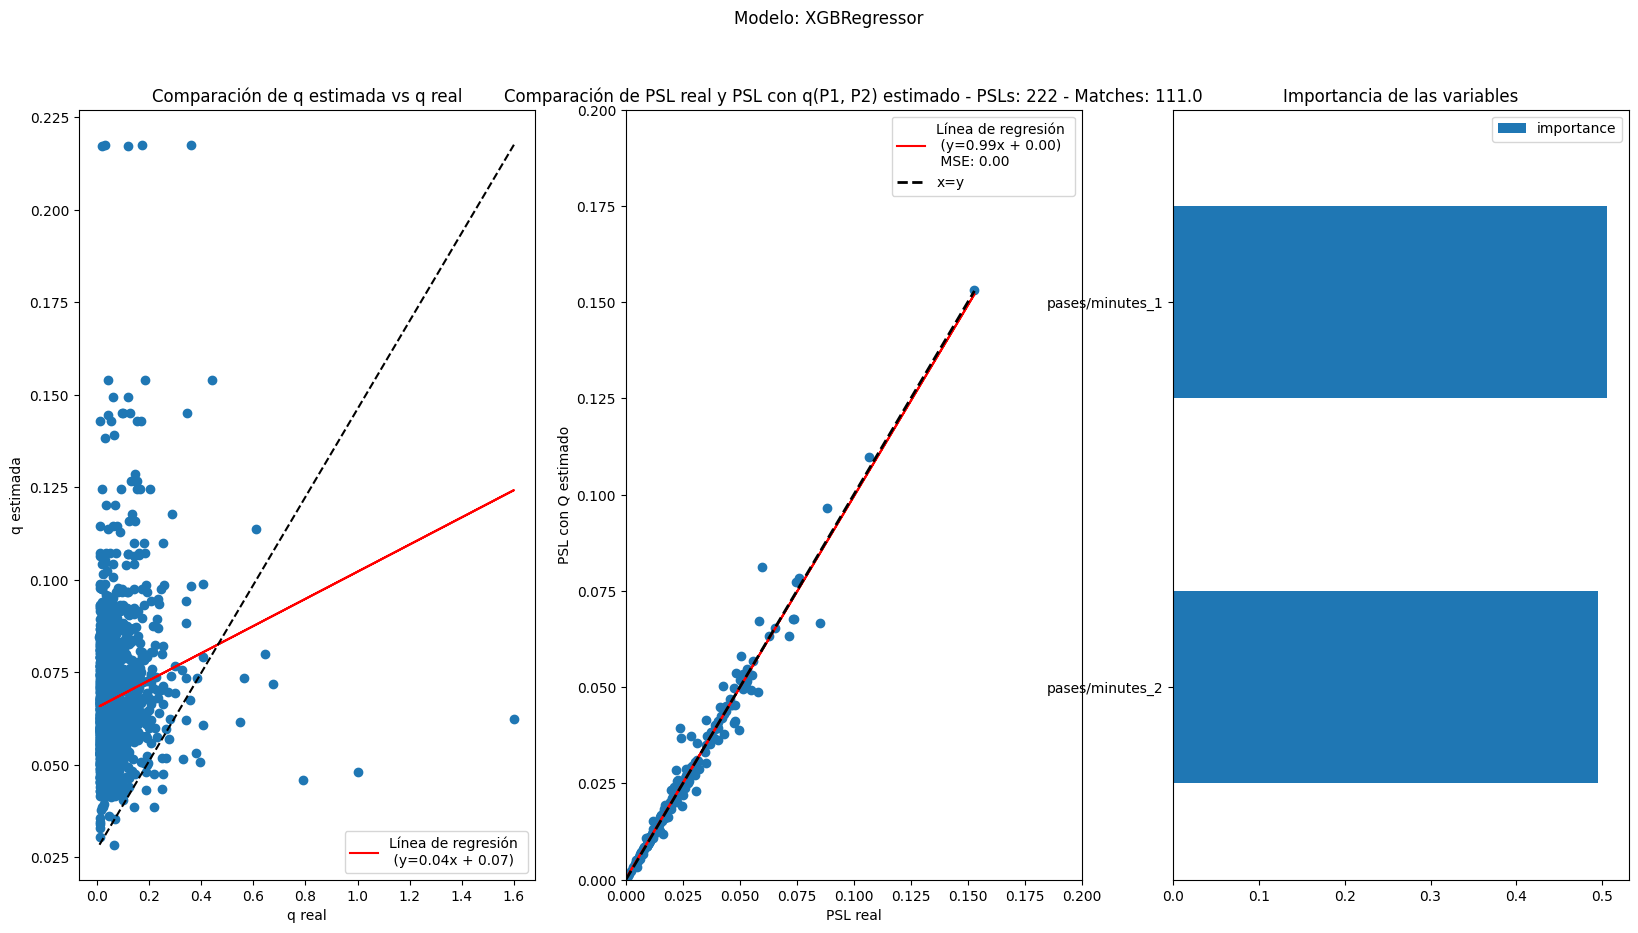

In [77]:
# Feature Engineering

X_train["pases/minutes_1"] = X_train["pases/90_1"] / X_train["minutes_1"]
X_train["pases/minutes_2"] = X_train["pases/90_2"] / X_train["minutes_2"]

X_test["pases/minutes_1"] = X_test["pases/90_1"] / X_test["minutes_1"]
X_test["pases/minutes_2"] = X_test["pases/90_2"] / X_test["minutes_2"]

player_features_df_alt = player_features_df.copy()
player_features_df_alt["pases/minutes"] = (
    player_features_df_alt["pases/90"] / player_features_df_alt["minutes"]
)

player_features_df_alt = player_features_df_alt.fillna(0)
subcols = ["pases/minutes"]
model_info(
    xgb.XGBRegressor(),
    X_train[[f"{col}_{i}" for i in range(1, 3) for col in subcols]],
    y_train,
    X_test[[f"{col}_{i}" for i in range(1, 3) for col in subcols]],
    y_test,
    R_storage,
    sample_pairs,
    matches,
    player_features_df_alt,
    cols=subcols,
)

/var/folders/5j/7b3w3dw95qdcll87vxc3yn300000gn/T/ipykernel_53898/2873766474.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train["shots/90_1"].replace(0, 1e-10, inplace=True)
/var/folders/5j/7b3w3dw95qdcll87vxc3yn300000gn/T/ipykernel_53898/2873766474.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting valu

Score: -0.08455265407250567 - MSE: 0.008080901643476744

 14%|█▍        | 16/111 [00:07<00:48,  1.98it/s, no_updates=0, updates=2239]

Error: La matriz es singular y no se puede invertir.
Singular matrix


 77%|███████▋  | 85/111 [00:33<00:08,  3.01it/s, no_updates=0, updates=11431]

Error: La matriz es singular y no se puede invertir.
Singular matrix


100%|██████████| 111/111 [00:43<00:00,  2.54it/s, no_updates=0, updates=14830]


(XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...),
 array([ 0.06362071,  0.09897187,  0.09897187, ...,  0.04200048,
        -0.00151835,  0.06332888], dtype=float32),
 -0.08455265407250567,
 np.float64(0.008080901643476744),
 np.float64(0.985226108628103),
 np.float64(0.00044469260608929334)

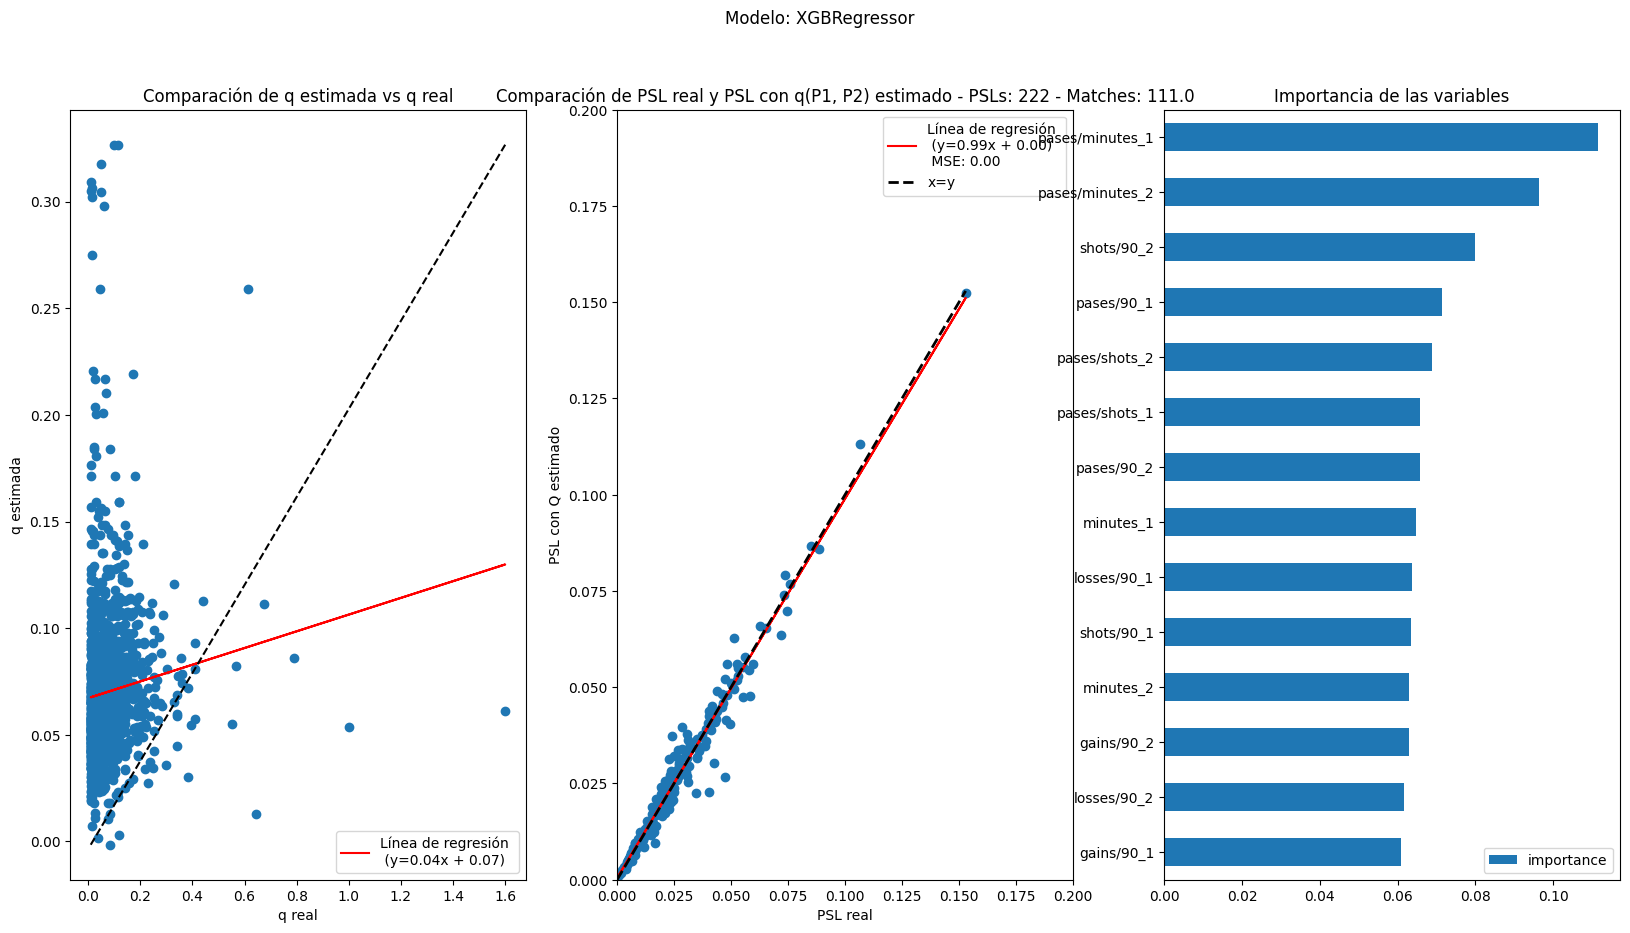

In [79]:
# Feature Engineering

X_train["pases/minutes_1"] = X_train["pases/90_1"] / X_train["minutes_1"]
X_train["pases/minutes_2"] = X_train["pases/90_2"] / X_train["minutes_2"]

X_test["pases/minutes_1"] = X_test["pases/90_1"] / X_test["minutes_1"]
X_test["pases/minutes_2"] = X_test["pases/90_2"] / X_test["minutes_2"]

player_features_df_alt = player_features_df.copy()
player_features_df_alt["pases/minutes"] = (
    player_features_df_alt["pases/90"] / player_features_df_alt["minutes"]
)

X_train["shots/90_1"].replace(0, 1e-10, inplace=True)
X_train["shots/90_2"].replace(0, 1e-10, inplace=True)
X_test["shots/90_1"].replace(0, 1e-10, inplace=True)
X_test["shots/90_2"].replace(0, 1e-10, inplace=True)
player_features_df_alt["shots/90"].replace(0, 1e-10, inplace=True)

# Calcular "pases/shots" evitando la división por cero
X_train["pases/shots_1"] = X_train["pases/90_1"] / X_train["shots/90_1"]
X_train["pases/shots_2"] = X_train["pases/90_2"] / X_train["shots/90_2"]

X_test["pases/shots_1"] = X_test["pases/90_1"] / X_test["shots/90_1"]
X_test["pases/shots_2"] = X_test["pases/90_2"] / X_test["shots/90_2"]

player_features_df_alt["pases/shots"] = (
    player_features_df_alt["pases/90"] / player_features_df_alt["shots/90"]
)

player_features_df_alt = player_features_df_alt.fillna(0)

model_info(
    xgb.XGBRegressor(),
    X_train,
    y_train,
    X_test,
    y_test,
    R_storage,
    sample_pairs,
    matches,
    player_features_df_alt,
    cols=list(set([col[:-2] for col in X_train.columns])),
)

## ALS - Alternating Least Squares

In [65]:
data = train_left
data.columns  # Index(['player_1', 'pases/90_1', 'shots/90_1', 'losses/90_1', 'gains/90_1',
#       'minutes_1', 'player_2', 'pases/90_2', 'shots/90_2', 'losses/90_2',
#       'gains/90_2', 'minutes_2', 'partido_id', 'target', 'date'],
#      dtype='object')

# recomendation_matrix is a matrix of:
#   columns of player_1 and player_2
#   rows of player_1 and player_2
#   values are the average target between the two players

players_1 = ds["player_1"].unique()
players_2 = ds["player_2"].unique()

players = np.unique(np.concatenate([players_1, players_2]))


recomendation_matrix = np.zeros((len(players), len(players)))

recomendation_matrix.shape

(521, 521)

In [66]:
for (i, player_1), (j, player_2) in tqdm(
    itertools.product(enumerate(players_1), enumerate(players_2))
):
    mask = (data["player_1"] == player_1) & (data["player_2"] == player_2)
    mask |= (data["player_1"] == player_2) & (data["player_2"] == player_1)
    recomendation_matrix[i, j] = data[mask]["target"].mean()

269880it [02:00, 2244.91it/s]


ValueError: Shape of passed values is (521, 521), indices imply (520, 519)

In [67]:
recomendation_matrix_df = pd.DataFrame(
    recomendation_matrix, index=players, columns=players
)

ratings = recomendation_matrix_df.fillna(0).values
matrix_size = np.prod(ratings.shape)
interaction = np.flatnonzero(ratings).shape[0]
sparsity = 100 * (interaction / matrix_size)

print("dimension: ", ratings.shape)
print("sparsity: {:.1f}%".format(sparsity))

dimension:  (521, 521)
sparsity: 3.6%


In [68]:
# ALS (Alternating Least Squares)


class ExplicitMF:
    """
    Train a matrix factorization model using Alternating Least Squares
    to predict empty entries in a matrix

    Parameters
    ----------
    n_iters : int
        number of iterations to train the algorithm

    n_factors : int
        number of latent factors to use in matrix
        factorization model, some machine-learning libraries
        denote this as rank

    reg : float
        regularization term for item/user latent factors,
        since lambda is a keyword in python we use reg instead
    """

    def __init__(self, n_iters, n_factors, reg):
        self.reg = reg
        self.n_iters = n_iters
        self.n_factors = n_factors

    def fit(self, train, test):
        """
        pass in training and testing at the same time to record
        model convergence, assuming both dataset is in the form
        of User x Item matrix with cells as ratings
        """
        self.n_user, self.n_item = train.shape
        self.user_factors = np.random.random((self.n_user, self.n_factors))
        self.item_factors = np.random.random((self.n_item, self.n_factors))

        # record the training and testing mse for every iteration
        # to show convergence later (usually, not worth it for production)
        self.test_mse_record = []
        self.train_mse_record = []
        for _ in range(self.n_iters):
            self.user_factors = self._als_step(
                train, self.user_factors, self.item_factors
            )
            self.item_factors = self._als_step(
                train.T, self.item_factors, self.user_factors
            )
            predictions = self.predict()
            test_mse = self.compute_mse(test, predictions)
            train_mse = self.compute_mse(train, predictions)
            self.test_mse_record.append(test_mse)
            self.train_mse_record.append(train_mse)

        return self

    def _als_step(self, ratings, solve_vecs, fixed_vecs):
        """
        when updating the user matrix,
        the item matrix is the fixed vector and vice versa
        """
        A = fixed_vecs.T.dot(fixed_vecs) + np.eye(self.n_factors) * self.reg
        b = ratings.dot(fixed_vecs)
        A_inv = np.linalg.inv(A)
        solve_vecs = b.dot(A_inv)
        return solve_vecs

    def predict(self):
        """predict ratings for every user and item"""
        pred = self.user_factors.dot(self.item_factors.T)
        return pred

    @staticmethod
    def compute_mse(y_true, y_pred):
        """ignore zero terms prior to comparing the mse"""
        mask = np.nonzero(y_true)
        mse = mean_squared_error(y_true[mask], y_pred[mask])
        return mse


def plot_learning_curve(model):
    """visualize the training/testing loss"""
    linewidth = 3
    plt.plot(model.test_mse_record, label="Test", linewidth=linewidth)
    plt.plot(model.train_mse_record, label="Train", linewidth=linewidth)
    plt.xlabel("iterations")
    plt.ylabel("MSE")
    plt.legend(loc="best")

In [69]:
def create_train_test(ratings):
    """
    split into training and test sets,
    remove 10 ratings from each user
    and assign them to the test set
    """
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in range(ratings.shape[0]):
        non_zero_indices = np.flatnonzero(ratings[user])
        if len(non_zero_indices) < 10:
            test_index = np.random.choice(
                non_zero_indices, size=len(non_zero_indices), replace=False
            )
        else:
            test_index = np.random.choice(non_zero_indices, size=10, replace=False)

        train[user, test_index] = 0.0
        test[user, test_index] = ratings[user, test_index]

    # assert that training and testing set are truly disjoint
    assert np.all(train * test == 0)
    return train, test


# Ejemplo de uso
train_rating, test_rating = create_train_test(ratings)

train_rating.shape, test_rating.shape

((521, 521), (521, 521))

In [70]:
# There are players in the test set that are not in the train set
# Add them to the train set with 0 rating
missing_players = set(recomendation_matrix_df.columns) - set(recomendation_matrix_df.index)

for player in missing_players:
    recomendation_matrix_df[player] = 0

recomendation_matrix_df = recomendation_matrix_df.fillna(0)
ratings = recomendation_matrix_df.values

train_rating, test_rating = create_train_test(ratings)
train_rating.shape, test_rating.shape

((521, 521), (521, 521))

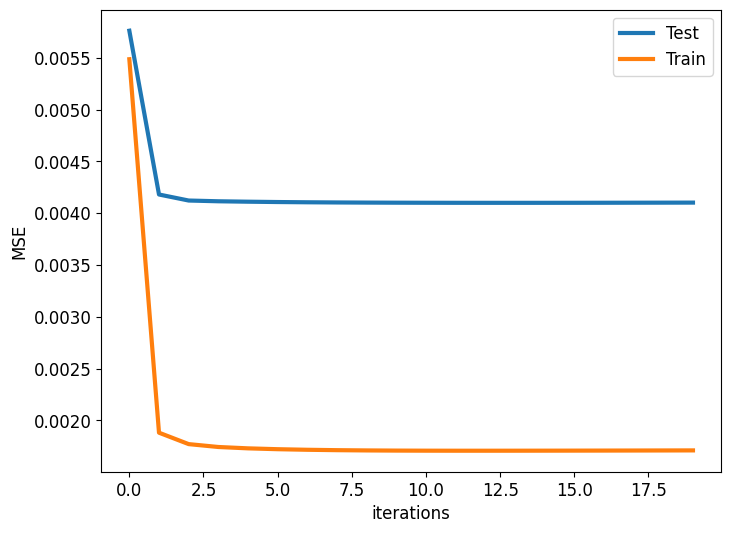

In [71]:
als = ExplicitMF(n_iters=20, n_factors=40, reg=0.01)
als.fit(train_rating, test_rating)
plot_learning_curve(als)

In [72]:
als_pred = als.predict()

als_pred_df = pd.DataFrame(als_pred, index=recomendation_matrix_df.index, columns=recomendation_matrix_df.columns)
als_pred_df

,3.0,160.0,363.0,1131.0,1195.0,1212.0,1216.0,1243.0,1256.0,1344.0,...,110403.0,111565.0,112516.0,114312.0,115556.0,125510.0,126184.0,132931.0,133798.0,148418.0
3.0,0.009603,0.013968,0.047061,0.015305,0.037621,0.018461,0.021456,-0.000094,0.007437,0.002138,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
160.0,0.045392,0.026161,0.062734,0.069421,0.056786,0.068919,0.059242,0.100667,0.072099,0.050983,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
363.0,0.029894,0.015251,0.013713,0.042059,0.030391,0.044649,0.023233,0.068622,0.043585,0.032705,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1131.0,0.038329,0.018048,0.019222,0.055213,0.034776,0.056503,0.033553,0.092942,0.059562,0.044647,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1195.0,0.024310,0.034244,0.100585,0.036183,0.091123,0.046361,0.043368,0.000784,0.015826,0.004533,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125510.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
126184.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
132931.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
133798.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [73]:
def replace_q_values_als(
    R_df,
    als_pred,
    p1,
    p2,
):
    # Given a 14x14 R matrix, replace the q values for p1, p2 with the model predictions
    # Get the features for p1 and p2 from the features_df
    # Get the model predictions for p1, p2
    # Replace the values in the R matrix
    # Return the updated R matrix

    q_1_2 = als_pred.loc[p1, p2]
    q_2_1 = als_pred.loc[p2, p1]

    R_df.loc[p1, p2] = q_1_2
    R_df.loc[p2, p1] = q_2_1

    return R_df, q_1_2, q_2_1


match_id_RS_index_map = {
    m: i
    for i, m in enumerate(
        [partido["match_id"].values[0] for partido in separar_partidos(epl)]
    )
}


def match_id_2_RS_index(match_id):
    return match_id_RS_index_map[match_id]


def get_psl_diffs_als(
    R_storage,
    als_pred,
    sample_pairs,
    matches,
):
    psls_diffs = []
    partidos = separar_partidos(matches)
    # pi_overhead = 380 - len(partidos)
    no_updates = 0
    updates = 0

    iterator = tqdm(partidos)
    for pi, partido in enumerate(iterator):
        try:
            match_id = partido["match_id"].values[0]
        except:
            continue

        for ti, equipo in enumerate(separar_partido_en_equipo_pov(partido)):
            team_psls = []
            team_alt_psls = []

            lineups = separar_partido_del_equipo_en_lineups(equipo)
            lineup_durations = np.array(
                [get_lineup_duration(lineup) for lineup in lineups]
            )

            for li, lineup in enumerate(lineups):
                jugadores = get_jugadores(lineup)
                team_rs_index = match_id_2_RS_index(match_id)
                R_f_s = R_storage[team_rs_index, ti, li].copy()
                # print("R from Storage:", R_f_s.shape)
                R_df = R_to_DataFrame(R_f_s, R_f_s[0, 2:13])
                # print("R DF:", R_df.shape)

                R = R_f_s[1:, 1:]
                # print("R 14x14: ", R.shape)
                real_psl = psl_estimator(build_Q(R))
                team_psls.append(real_psl)

                R_mod = R.copy()

                # Check jugadores are in R_df [0, 2:13]
                if not all([jugador in R_df.columns for jugador in jugadores]):
                    # print(pi + pi_overhead, ti, li, jugadores)
                    # print(lineup_durations[li])
                    # visualize_R_matrix(R_f_s)
                    team_alt_psls.append(0)
                    continue

                for i, player in enumerate(jugadores):
                    if player in sample_pairs["player_1"].values:
                        for j, player2 in enumerate(jugadores):
                            if player2 != player:
                                # tmp = R_df.loc[player, player2]
                                tmp_R = R[i + 1, j + 1]
                                R_df, q_1_2, q_2_1 = replace_q_values_als(
                                    R_df, als_pred, player, player2
                                )
                                R_mod[i + 1, j + 1] = q_1_2
                                R_mod[j + 1, i + 1] = q_2_1
                                # post = R_df.loc[player, player2]
                                post_R = R_mod[i + 1, j + 1]
                                # if tmp == post:
                                # raise ValueError("No update")

                                if tmp_R == post_R:
                                    no_updates += 1
                                else:
                                    updates += 1
                                    # print(no_updates)
                                    # raise ValueError("No update")

                # R = np.array(R_df.values)
                # print(R.shape)
                modified_psl = psl_estimator(build_Q(R_mod))
                if real_psl == modified_psl:
                    iterator.set_postfix(
                        {
                            "no_updates": no_updates,
                            "updates": updates,
                        }
                    )

                    # raise ValueError("No update")
                team_alt_psls.append(modified_psl)

            psl = np.average(team_psls, weights=lineup_durations)
            psl_alt = np.average(team_alt_psls, weights=lineup_durations)
            psls_diffs.append((psl, psl_alt))

    return psls_diffs

In [34]:
matches = epl[epl["date"] >= date_2_3]

 19%|█▉        | 21/111 [00:00<00:01, 45.24it/s, no_updates=499, updates=2741]

Error: La matriz es singular y no se puede invertir.
Singular matrix


 79%|███████▉  | 88/111 [00:02<00:00, 43.17it/s, no_updates=1801, updates=10140]

Error: La matriz es singular y no se puede invertir.
Singular matrix


100%|██████████| 111/111 [00:02<00:00, 44.75it/s, no_updates=2242, updates=12281]


(np.float64(0.9847264283056574),
 np.float64(-0.0008677778927390009),
 np.float64(1.0809177106547568e-05))

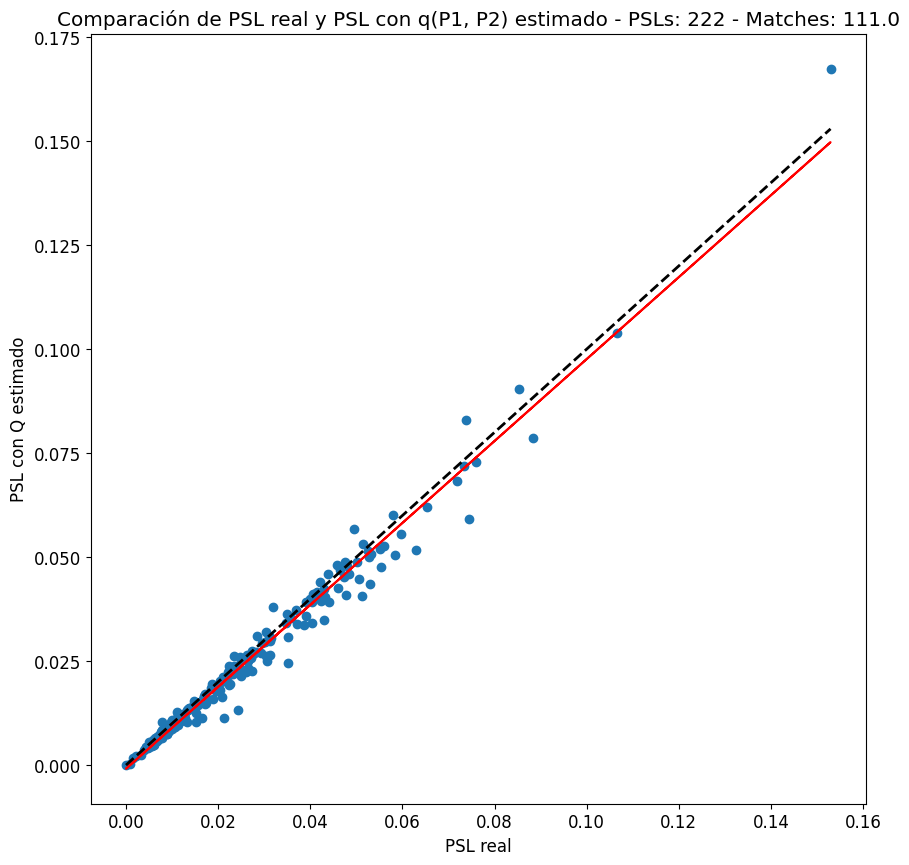

In [75]:
evaluate_psl_diffs(np.array(get_psl_diffs_als(R_storage, als_pred_df, sample_pairs, matches)))

In [86]:
y_test = test_right["target"]
preds = []

for _, row in test_right.iterrows():
    player_1 = row["player_1"]
    player_2 = row["player_2"]

    pred = als_pred_df.loc[player_1, player_2]
    preds.append(pred)

y_pred = np.array(preds)

y_test.shape, y_pred.shape


((1362,), (1362,))

 19%|█▉        | 21/111 [00:00<00:02, 40.69it/s, no_updates=496, updates=2676]

Error: La matriz es singular y no se puede invertir.
Singular matrix


 83%|████████▎ | 92/111 [00:02<00:00, 43.29it/s, no_updates=1801, updates=10140]

Error: La matriz es singular y no se puede invertir.
Singular matrix


100%|██████████| 111/111 [00:02<00:00, 41.28it/s, no_updates=2242, updates=12281]
/var/folders/5j/7b3w3dw95qdcll87vxc3yn300000gn/T/ipykernel_90404/2199082731.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1].legend()


Score: 0.0006267360748236639 - MSE: 0.009890119439863837

PSL Slope: 0.9847264283056574 - PSL Intercept: -0.0008677778927390009 - PSL MSE: 1.0809177106547568e-05

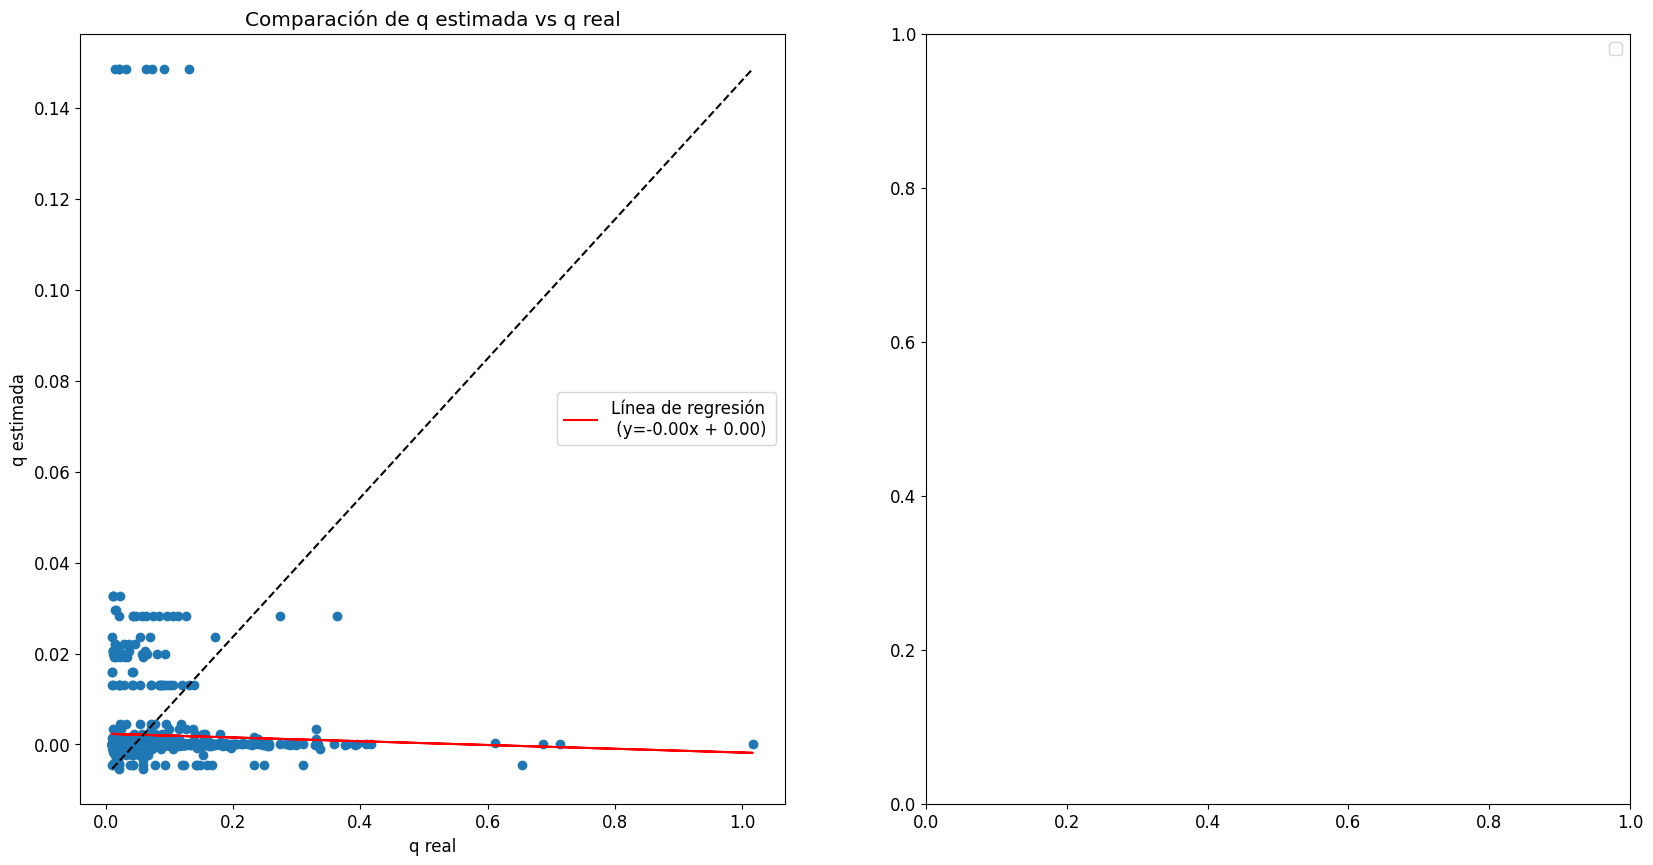

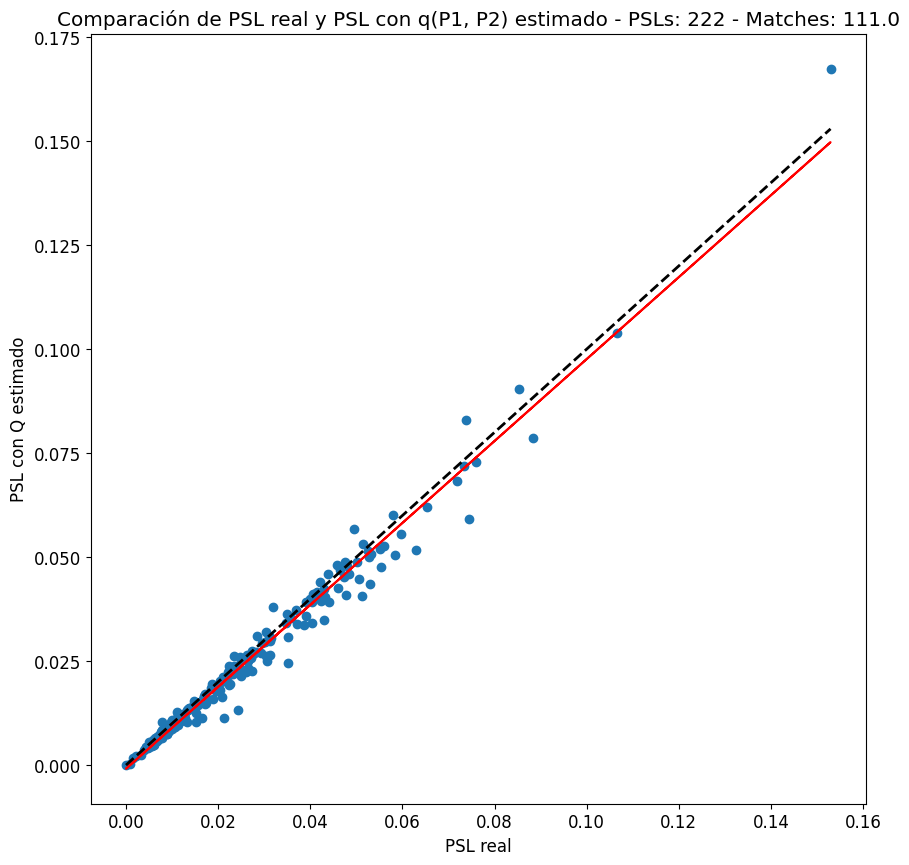

In [90]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

psl_slope, psl_intercept, psl_mse = evaluate_psl_diffs(
    np.array(get_psl_diffs_als(R_storage, als_pred_df, sample_pairs, matches))
)

axs[1].legend()

axs[0].scatter(y_test, y_pred)

# Regresión lineal para los datos, comparar la pendiente con y=x
reg = LinearRegression().fit(y_test.values.reshape(-1, 1), y_pred)
y_pred_line = reg.predict(y_test.values.reshape(-1, 1))

# Obtener la pendiente (slope) y la intersección (intercept)
q_slope = reg.coef_[0]
q_intercept = reg.intercept_

axs[0].plot(
    y_test,
    y_pred_line,
    color="red",
    label=f"Línea de regresión \n (y={q_slope:.2f}x + {q_intercept:.2f})",
)

# Plot y=x for the range of the data
axs[0].plot([y_test.min(), y_test.max()], [y_pred.min(), y_pred.max()], "k--")

axs[0].set_xlabel("q real")
axs[0].set_ylabel("q estimada")
axs[0].set_title("Comparación de q estimada vs q real")

axs[0].legend()

sc = reg.score(y_test.values.reshape(-1, 1), y_pred)
mse = mean_squared_error(y_test, y_pred)

display(Markdown(f"Score: {sc} - MSE: {mse}"))
display(Markdown(f"PSL Slope: {psl_slope} - PSL Intercept: {psl_intercept} - PSL MSE: {psl_mse}"))

## Neural Network

In [34]:
!pip install torch

  Using cached torch-2.2.2-cp310-none-macosx_10_9_x86_64.whl.metadata (25 kB)
  Using cached filelock-3.16.1-py3-none-any.whl.metadata (2.9 kB)
  Using cached sympy-1.13.3-py3-none-any.whl.metadata (12 kB)
  Using cached networkx-3.3-py3-none-any.whl.metadata (5.1 kB)
  Using cached jinja2-3.1.4-py3-none-any.whl.metadata (2.6 kB)
  Using cached MarkupSafe-2.1.5-cp310-cp310-macosx_10_9_x86_64.whl.metadata (3.0 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.8/150.8 MB 437.2 kB/s eta 0:00:0000:0100:09
Using cached networkx-3.3-py3-none-any.whl (1.7 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 307.2 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 263.2 kB/s eta 0:00:00:--:--


In [6]:
import torch
from torch import nn

# device = (
#     "cuda"
#     if torch.cuda.is_available()
#     else "mps" if torch.backends.mps.is_available() else "cpu"
# )
device = "cpu"
print(f"Using {device} device")


class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(10, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 1),
        )

    def forward(self, x):
        print(x.shape)
        logits = self.linear_relu_stack(x)
        print(logits)
        return logits


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/Users/nacho/Desktop/code/understat-xg/.conda/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Users/nacho/Desktop/code/understat-xg/.conda/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/Users/nacho/Desktop/code/understat-xg/.conda/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/nacho/Desktop/code/understat-xg/.conda/lib/python3.10/site-packag

Using cpu device


In [7]:
model = NeuralNetwork()

In [9]:
X_train = train_left.drop(
    columns=["player_1", "player_2", "target", "date", "partido_id"]
)
y_train = train_left["target"]

X_test = test_right.drop(
    columns=["player_1", "player_2", "target", "date", "partido_id"]
)
y_test = test_right["target"]

In [10]:
inputs = torch.tensor(X_train.loc[0])
labels = torch.tensor(y_train.loc[0])

inputs, labels

/var/folders/5j/7b3w3dw95qdcll87vxc3yn300000gn/T/ipykernel_51666/1682424614.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(X_train.loc[0])


(tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), tensor(0.0806))

In [ ]:
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


def train(X_train, y_train, model, loss_fn, optimizer, epochs):
    iterator = tqdm(range(epochs))
    for t in iterator:
        for i, row in X_train.iterrows():
            inputs = torch.tensor(row.values)
            labels = torch.tensor(y_train.loc[i])

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

        # print(f"Epoch {t}, Loss: {loss.item()}")
        iterator.set_postfix(
            {"Loss": loss.item(), "Epoch": t, "Score": model(inputs).item()}
        )

In [11]:
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

def train(X_train, y_train, model, loss_fn, optimizer, epochs):
    iterator = tqdm(range(epochs))
    for t in iterator:
        for i, row in X_train.iterrows():
            inputs = torch.tensor(row.values)
            labels = torch.tensor(y_train.loc[i])

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

        # print(f"Epoch {t}, Loss: {loss.item()}")
        iterator.set_postfix({
            "Loss": loss.item(),
            "Epoch": t,
            "Score": model(inputs).item()   
        })

# Train the model
train(X_train, y_train, model, loss_fn, optimizer, 10)

# Evaluate the model
y_pred = []

for i, row in X_test.iterrows():
    inputs = torch.tensor(row.values)
    y_pred.append(model(inputs).item())

y_pred = np.array(y_pred)

sc = model(inputs).item()
mse = mean_squared_error(y_test, y_pred)

display(Markdown(f"Score: {sc} - MSE: {mse}"))

fig, ax = plt.subplots(figsize=(10, 10))

ax.scatter(y_test, y_pred)

# Plot regression line
reg = LinearRegression().fit(np.array(y_test).reshape(-1, 1), y_pred)
y_pred_line = reg.predict(np.array(y_test).reshape(-1, 1))
q_slope = reg.coef_[0]
q_intercept = reg.intercept_

# Dibujar la línea de regresión
ax.plot(y_test, y_pred_line, color="red", label=f"Línea de regresión \n (y={q_slope:.2f}x + {q_intercept:.2f})")

ax.legend()

  0%|          | 0/10 [00:00<?, ?it/s]

: 